# ST311 Project: Tennis Hit Frame and Landing Spot Prediction

This notebook implements and evaluates a two-stage deep learning pipeline for tennis shot prediction using PyTorch.

1.  **Hit Frame Regression (CNN1):** Identifies the most likely frame where a ball is hit using a CNN trained on weighted frame data.
2.  **Landing Spot Prediction (CNN2):** Predicts the normalised landing coordinates using a CNN that processes a sequence of frames around the hit.

A GitHub repo containing code used to train the models outside of an .ipynb can be found at this link: https://github.com/crypanon/st311_tennis_analysis

A viewable Google Colab .ipynb can be found at this link: https://colab.research.google.com/drive/1iwguRffa8TViMxqrrzpv4jKF7ZzFfeSQ?usp=sharing

## Setup

Imports PyTorch for deep learning framework, Pillow for image operations, and Kaggle and Google Drive for data imports.

In [ ]:
# --- Core Libraries ---
import os
import pandas as pd
import numpy as np
import cv2 # OpenCV
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import re # For extracting frame numbers
from google.colab import drive
import kagglehub
from tqdm.notebook import tqdm # Progress bars for Colab
import warnings
from PIL import Image # For augmentation
import collections # For deque in live prediction example
from torchvision import transforms # For live prediction preprocessing
import gc # Garbage collection
import time
import base64

# --- Suppress Warnings ---
warnings.filterwarnings('ignore', category=UserWarning, module='torch.utils.data')

# --- Check PyTorch and CUDA ---
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")

# # --- Mount Google Drive ---
# # This path will store outputs like models and results CSVs.
# try:
#     drive.mount('/content/drive')
#     # !! MODIFY project_path if your Drive structure is different !!
#     project_path = '/content/drive/MyDrive/ST311 Project/'
#     print(f"Google Drive mounted. Project Path: {project_path}")
#     os.makedirs(project_path, exist_ok=True)
# except Exception as e:
#     print(f"Error mounting Google Drive: {e}")
#     print("Using local Colab storage ('./') for outputs.")
#     project_path = './'
#     os.makedirs(project_path, exist_ok=True)

# --- Kaggle API Login (Needed for Dataset Download) ---
try:
    kagglehub.login()
    print("Kaggle login successful (using stored credentials or prompted).")
except Exception as e:
    print(f"Kaggle login failed: {e}")
    print("Dataset download might fail if credentials are not configured.")

PyTorch version: 2.6.0+cu124
CUDA Available: True
CUDA Device Name: Tesla T4


Kaggle login successful (using stored credentials or prompted).


## Configuration

Instantiates training parameters and model hyperparameters (retrieved from grid search).

In [ ]:
# --- Core Parameters ---
IMG_HEIGHT = 224
IMG_WIDTH = 224
SEED = 42 # For reproducibility

# --- Device Setup ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True # Enable CuDNN benchmark mode for potentially faster convolutions
print(f"Using device: {DEVICE}")

# --- Final Hyperparameters (Determined from Offline Tuning) ---
# CNN1 (Hit Frame Regression)
CNN1_LEARNING_RATE = 5e-4
CNN1_BATCH_SIZE = 16
CNN1_N_FRAMES_WEIGHTING = 9
CNN1_WEIGHT_DECAY = 0.3
CNN1_BALANCE_RATIO = 4
# Architecture params from search
CNN1_FILTERS = (32, 32, 64, 64)
CNN1_FC_SIZE = 512
CNN1_DROPOUT = 0.5

# CNN2 (Landing Spot Prediction)
CNN2_N_FRAMES_SEQUENCE = 9
CNN2_LEARNING_RATE = 5e-5
CNN2_BATCH_SIZE = 16
CNN2_INPUT_CHANNELS = CNN2_N_FRAMES_SEQUENCE * 3
# Architecture params from search
CNN2_CONV_FILTERS = (128, 256, 512, 512)
CNN2_FC_SIZES = (512, 256)
CNN2_DROPOUT = 0.5

# Training Control
FINAL_TRAINING_EPOCHS = 50 # Max epochs for final training runs
EARLY_STOPPING_PATIENCE = 15 # Patience for final training
MIN_IMPROVEMENT = 1e-5   # Min loss improvement for early stopping

# DataLoaders
NUM_WORKERS = 2 # Number of parallel workers for data loading
PIN_MEMORY = True if DEVICE.type == 'cuda' else False

# Court Dimensions (for coordinate mapping)
DOUBLES_COURT_WIDTH_M = 10.97
HALF_COURT_LENGTH_M = 11.89

# --- Set Seed ---
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Using device: cuda


## Data Acquisition

### Download Kaggle Dataset

Downloads dataset of frames, extracted from videos externally and then uploaded to Kaggle.

In [ ]:
def decode_hex(hex_string):
    try:
        decoded = bytes.fromhex(hex_string).decode('utf-8')
        return decoded
    except ValueError as e:
        return f"Invalid hex string: {e}"

# Path to store dataset (kagglehub default or specify)
dataset_base_path = None
try:
    print("Downloading/Verifying dataset")
    # Let kagglehub manage the download path
    name = decode_hex('6a6f656b696e646572') # Kaggle username encoded to preserve project anonymity
    kaggle_path = name + '/st311-tennis'
    dataset_base_path = kagglehub.dataset_download(kaggle_path)
    project_path = dataset_base_path
    print(f"Dataset path: {dataset_base_path}")
    if not os.path.exists(dataset_base_path):
        raise FileNotFoundError(f"Kaggle dataset path not found after download: {dataset_base_path}")
    print("Dataset path verified.")
except Exception as e:
    print(f"Error during Kaggle download: {e}")
    print("Please ensure Kaggle API is configured or data is manually placed.")
    # Optionally set dataset_base_path manually if downloaded elsewhere:
    # dataset_base_path = '/content/your_manual_path/st311-tennis'
    if dataset_base_path is None or not os.path.exists(dataset_base_path):
         raise RuntimeError("Failed to set dataset path via Kaggle or manually.")

Downloading/Verifying dataset
Dataset path: /kaggle/input/st311-tennis
Dataset path verified.


### Load Metadata CSV (hit_frames.csv)

Loads hit_frames.csv which is a file containing the frame in which the ball hits the tennis racket - or the nearest frame to this if not available.

In [ ]:
print("Loading hit_frames.csv and preparing frame paths...")
csv_path = os.path.join(dataset_base_path, 'hit_frames.csv')
print(f"Looking for CSV at: {csv_path}")

try:
    df_meta = pd.read_csv(csv_path)
    print(f"Original CSV loaded with {len(df_meta)} rows.")

    # Construct Full Absolute Paths using the downloaded dataset path
    df_meta['frame_path'] = df_meta['frame_path'].apply(
        lambda x: os.path.join(dataset_base_path, 'Frames',x.replace('\\', '/'))
    )
    # Add video_id (directory containing the frame) for grouping
    df_meta['video_id'] = df_meta['frame_path'].apply(lambda x: os.path.dirname(x))

    # Basic Data Inspection
    print(f"Loaded {len(df_meta)} frame references.")
    if not df_meta.empty:
        print(f"  Hit frames (is_hit_frame == 1): {len(df_meta[df_meta['is_hit_frame'] == 1])}")
        print(f"  Non-hit frames (is_hit_frame == 0): {len(df_meta[df_meta['is_hit_frame'] == 0])}")
        # Check a sample path
        sample_path = df_meta['frame_path'].iloc[random.randint(0, len(df_meta)-1)]
        print(f"Checking sample path: {sample_path}")
        if not os.path.exists(sample_path):
             print(f"Warning: Sample frame path does NOT exist!")
        else:
             print("Sample frame path exists.")
    else:
        print("Warning: DataFrame is empty after loading CSV.")

except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure '{os.path.basename(csv_path)}' exists at the expected location.")
    raise e
except Exception as e:
    print(f"An unexpected error occurred during metadata loading: {e}")
    raise e

print("\nMetadata DataFrame head:")
print(df_meta[['frame_path', 'video_id', 'is_hit_frame']].head())

Loading hit_frames.csv and preparing frame paths...
Looking for CSV at: /kaggle/input/st311-tennis/hit_frames.csv
Original CSV loaded with 27642 rows.
Loaded 27642 frame references.
  Hit frames (is_hit_frame == 1): 1652
  Non-hit frames (is_hit_frame == 0): 25990
Checking sample path: /kaggle/input/st311-tennis/Frames/Frames/Outdoor Field/Cross-court Shot/Top-View/OCT13/frame_0017.jpg
Sample frame path exists.

Metadata DataFrame head:
                                          frame_path  \
0  /kaggle/input/st311-tennis/Frames/Frames/Outdo...   
1  /kaggle/input/st311-tennis/Frames/Frames/Outdo...   
2  /kaggle/input/st311-tennis/Frames/Frames/Outdo...   
3  /kaggle/input/st311-tennis/Frames/Frames/Outdo...   
4  /kaggle/input/st311-tennis/Frames/Frames/Outdo...   

                                            video_id  is_hit_frame  
0  /kaggle/input/st311-tennis/Frames/Frames/Outdo...             1  
1  /kaggle/input/st311-tennis/Frames/Frames/Outdo...             1  
2  /kaggle/inpu

### Coordinate Mapping Function

Maps coordinates which depend on type of shot (Cross-Court/Straight) to a standardised coordinate system.

In [ ]:
def map_coordinates(dist_sideline, dist_baseline, shot_type, court_width, court_length):
    """Maps raw distances (m) to normalized [0, 1] coordinates."""
    if pd.isna(dist_sideline) or pd.isna(dist_baseline) or pd.isna(shot_type) or \
       shot_type not in ['Straight', 'Cross'] or court_width <= 0 or court_length <= 0:
        return None, None # Return tuple of Nones

    y_norm = (dist_baseline / court_length)

    if shot_type == 'Straight': # Lands near RIGHT sideline (X near 1)
        x_norm = (court_width - dist_sideline) / court_width
    else: # Cross, lands near LEFT sideline (X near 0)
        x_norm = dist_sideline / court_width

    return np.clip(x_norm, 0.0, 1.0), np.clip(y_norm, 0.0, 1.0)

# --- Test the function ---
print("\nTesting coordinate mapping:")
nx_s, ny_s = map_coordinates(1.0, 6.0, 'Straight', DOUBLES_COURT_WIDTH_M, HALF_COURT_LENGTH_M)
nx_c, ny_c = map_coordinates(1.0, 6.0, 'Cross', DOUBLES_COURT_WIDTH_M, HALF_COURT_LENGTH_M)
print(f"  Straight (1m from R sideline, 6m baseline): Norm ~ ({nx_s:.3f}, {ny_s:.3f})")
print(f"  Cross    (1m from L sideline, 6m baseline): Norm ~ ({nx_c:.3f}, {ny_c:.3f})")


Testing coordinate mapping:
  Straight (1m from R sideline, 6m baseline): Norm ~ (0.909, 0.505)
  Cross    (1m from L sideline, 6m baseline): Norm ~ (0.091, 0.505)


### Load Landing Coordinate CSVs

Loads landing coordinate CSVs and applies mapping function to coordinates.

In [ ]:
csv_base_path = os.path.join(dataset_base_path)
print(f"\nLooking for landing CSVs in: {csv_base_path}")

# if not os.path.isdir(csv_base_path):
#     # Attempt fallback relative to project path (e.g., if manually copied to Drive)
#     csv_base_path_fallback = os.path.join(project_path, 'Videos')
#     print(f"Warning: Standard landing CSV directory not found. Trying fallback: {csv_base_path_fallback}")
#     if os.path.isdir(csv_base_path_fallback):
#         csv_base_path = csv_base_path_fallback
#     else:
#         raise FileNotFoundError(f"Landing CSV directory not found at primary ({csv_base_path}) or fallback ({csv_base_path_fallback}) location.")

csv_files = {
    "Indoor_Cross": "Indoor Field - Crosscourt Shot.csv",
    "Indoor_Straight": "Indoor Field - Straight Shot.csv",
    "Outdoor_Cross": "Outdoor Field - Crosscourt Shot.csv",
    "Outdoor_Straight": "Outdoor Field - Straight Shot.csv",
}
# Prefixes MUST match the video folder names (e.g., ICT01, IST82)
prefix_map = {"Indoor_Cross": "ICT", "Indoor_Straight": "IST", "Outdoor_Cross": "OCT", "Outdoor_Straight": "OST"}

all_landing_data = []
print("Loading and processing landing location CSVs...")
for name, filename in csv_files.items():
    filepath = os.path.join(csv_base_path, filename)
    if not os.path.exists(filepath):
        print(f"Warning: Landing CSV not found: {filepath}. Skipping.")
        continue
    try:
        df_landing_temp = pd.read_csv(filepath)
        print(f"  Loaded {len(df_landing_temp)} rows from {filename}")

        env, shot = name.split('_')
        df_landing_temp['Environment'] = env
        df_landing_temp['ShotType'] = shot
        df_landing_temp.rename(columns={
            'Index': 'OriginalIndex',
            'To-Closest-Doubles-Sideline-Distance (m)': 'DistSideline',
            'To-Baseline-Distance (m)': 'DistBaseline'
        }, inplace=True, errors='ignore')

        req_cols = ['OriginalIndex', 'DistSideline', 'DistBaseline', 'ShotType']
        if not all(col in df_landing_temp.columns for col in req_cols):
            print(f"Error: Missing required cols in {filename}. Skipping.")
            continue

        file_prefix = prefix_map.get(name, "UNK")
        # Generate ShotID (e.g., IST01) - crucial link
        df_landing_temp['ShotID'] = file_prefix + df_landing_temp['OriginalIndex'].astype(str).str.zfill(2)

        coords = df_landing_temp.apply(lambda row: map_coordinates(
            row['DistSideline'], row['DistBaseline'], row['ShotType'],
            DOUBLES_COURT_WIDTH_M, HALF_COURT_LENGTH_M), axis=1)
        df_landing_temp[['NormX', 'NormY']] = pd.DataFrame(coords.tolist(), index=df_landing_temp.index)

        rows_before = len(df_landing_temp)
        df_landing_temp.dropna(subset=['NormX', 'NormY'], inplace=True)
        if len(df_landing_temp) < rows_before:
             print(f"    Dropped {rows_before - len(df_landing_temp)} rows with invalid coords.")

        final_cols = ['ShotID', 'NormX', 'NormY'] # Keep only essential columns + ShotID
        all_landing_data.append(df_landing_temp[final_cols])

    except Exception as e:
        print(f"Error processing {filename}: {e}")

if not all_landing_data:
    raise RuntimeError("No landing data loaded. Cannot proceed.")

landing_df = pd.concat(all_landing_data, ignore_index=True)
print(f"\nCombined landing data: {len(landing_df)} valid entries.")
landing_df.set_index('ShotID', inplace=True, verify_integrity=True) # Use ShotID as unique index
print("Landing DataFrame prepared with 'ShotID' index.")
print(landing_df.head())


Looking for landing CSVs in: /kaggle/input/st311-tennis
Loading and processing landing location CSVs...
  Loaded 99 rows from Indoor Field - Crosscourt Shot.csv
  Loaded 99 rows from Indoor Field - Straight Shot.csv
  Loaded 20 rows from Outdoor Field - Crosscourt Shot.csv
  Loaded 18 rows from Outdoor Field - Straight Shot.csv

Combined landing data: 236 valid entries.
Landing DataFrame prepared with 'ShotID' index.
           NormX     NormY
ShotID                    
ICT01   0.278943  0.318755
ICT02   0.202370  0.269134
ICT03   0.273473  0.423886
ICT04   0.176846  0.253154
ICT05   0.154057  0.170732


## Data Preprocessing & Splitting

### Linear Weight Assignment

Assigns weights to frames of each video - with max weight assigned to identified hit frame, and weights decaying linearly on frames either side of hit frame. Parameters defined in config cell.

In [ ]:
# Define the linear weighting function (used for standard CNN1 training)
def assign_linear_weights(group, total_frames_window, decay_rate):
    """Assigns weights based on proximity using linear decay."""
    group = group.copy()
    group['weight'] = 0.0
    hit_frames = group[group['is_hit_frame'] == 1]
    if hit_frames.empty: return group

    middle_hit_idx = len(hit_frames) // 2
    middle_hit_row = hit_frames.iloc[middle_hit_idx]
    middle_hit_frame_index_in_group = middle_hit_row.name

    middle_frame_num = None
    try:
        match = re.search(r'frame_(\d+)', os.path.basename(middle_hit_row['frame_path']))
        if match: middle_frame_num = int(match.group(1))
    except Exception: pass
    if middle_frame_num is None:
        middle_frame_num = group.index.get_loc(middle_hit_frame_index_in_group)

    window_half = total_frames_window // 2
    weights = {}
    for idx, row in group.iterrows():
        current_frame_num = None
        try:
            match = re.search(r'frame_(\d+)', os.path.basename(row['frame_path']))
            if match: current_frame_num = int(match.group(1))
        except Exception: pass
        if current_frame_num is None: current_frame_num = group.index.get_loc(idx)

        distance = abs(current_frame_num - middle_frame_num)
        if idx == middle_hit_frame_index_in_group: weight = 1.0
        elif distance <= window_half: weight = max(0.0, 1.0 - (distance * decay_rate))
        else: weight = 0.0
        weights[idx] = weight

    group['weight'] = group.index.map(weights)
    return group

# Apply linear weighting using final hyperparameters
print(f"\nApplying LINEAR weight assignment (Window={CNN1_N_FRAMES_WEIGHTING}, Decay={CNN1_WEIGHT_DECAY})...")
df_weighted_linear = df_meta.copy() # Start from original metadata
df_weighted_linear['weight'] = 0.0
try:
    tqdm.pandas(desc="Assigning Linear Weights")
    df_weighted_linear = df_weighted_linear.groupby('video_id', group_keys=False).progress_apply(
        assign_linear_weights, total_frames_window=CNN1_N_FRAMES_WEIGHTING, decay_rate=CNN1_WEIGHT_DECAY
    )
    df_weighted_linear = df_weighted_linear.reset_index(drop=True)
    print("Linear weight assignment complete.")
    print(f"  Frames with weight > 0: {len(df_weighted_linear[df_weighted_linear['weight'] > 0])}")
except Exception as e:
    print(f"Error during linear weight assignment: {e}")
    raise e


Applying LINEAR weight assignment (Window=9, Decay=0.3)...


Assigning Linear Weights:   0%|          | 0/236 [00:00<?, ?it/s]

Linear weight assignment complete.
  Frames with weight > 0: 1652


### CNN1: Data Balancing & Splitting

Splits the data into Train/Test/Val, and stratifies to balance the weight of zero weighted frames to non-zero weighted frames. Parameters found using grid search and defined in config cell.

In [ ]:
def balance_and_split_data(df_weighted, balance_ratio, test_size=0.1, val_size=0.1):
    """Balances based on weight > 0 and splits into train/val/test."""
    print(f"\nBalancing dataset (Ratio Non-Hit/Weighted: {balance_ratio}) and Splitting...")
    if 'weight' not in df_weighted.columns: raise ValueError("'weight' column missing.")

    hit_frames_weighted = df_weighted[df_weighted['weight'] > 0].copy()
    non_hit_frames = df_weighted[df_weighted['weight'] == 0].copy()
    print(f"  Frames with weight > 0: {len(hit_frames_weighted)}")
    print(f"  Frames with weight == 0: {len(non_hit_frames)}")

    if hit_frames_weighted.empty: print("Warning: No frames with weight > 0 found.")
    if non_hit_frames.empty: print("Warning: No non-hit frames found.")

    # Sample non-hit frames
    target_non_hit_count = int(balance_ratio * len(hit_frames_weighted))
    sample_size = min(len(non_hit_frames), target_non_hit_count)
    print(f"  Sampling {sample_size} non-hit frames...")
    sampled_non_hit = non_hit_frames.sample(n=sample_size, random_state=SEED) if sample_size > 0 else pd.DataFrame()

    balanced_df = pd.concat([hit_frames_weighted, sampled_non_hit])
    balanced_df = balanced_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    print(f"  Balanced dataset size: {len(balanced_df)}")

    # Prepare for splitting
    all_paths = balanced_df['frame_path'].tolist()
    all_paths = [os.path.join('Frames', path) for path in all_paths]
    all_targets = balanced_df['weight'].tolist() # Targets for CNN1 are weights
    stratify_labels = (np.array(all_targets) > 0).astype(int)

    if len(all_paths) < 3: raise ValueError("Not enough data for train/val/test split.")

    # Split Test set first
    train_val_paths, test_paths, train_val_targets, test_targets = train_test_split(
        all_paths, all_targets, test_size=test_size, random_state=SEED, stratify=stratify_labels
    )
    # Split Train/Val from remainder
    relative_val_size = val_size / (1.0 - test_size) if (1.0 - test_size) > 0 else 0
    train_paths, val_paths, train_targets, val_targets = train_test_split(
        train_val_paths, train_val_targets, test_size=relative_val_size, random_state=SEED,
        stratify=(np.array(train_val_targets) > 0).astype(int) # Stratify remaining
    )

    print(f"Data Splitting Results:")
    print(f"  Training samples:   {len(train_paths)}")
    print(f"  Validation samples: {len(val_paths)}")
    print(f"  Test samples:       {len(test_paths)}")
    return balanced_df, train_paths, train_targets, val_paths, val_targets, test_paths, test_targets

# Perform balancing and splitting for standard CNN1 training
df_balanced_cnn1, train_paths_cnn1, train_weights_cnn1, val_paths_cnn1, val_weights_cnn1, test_paths_cnn1, test_weights_cnn1 = \
    balance_and_split_data(df_weighted_linear, CNN1_BALANCE_RATIO)


Balancing dataset (Ratio Non-Hit/Weighted: 4) and Splitting...
  Frames with weight > 0: 1652
  Frames with weight == 0: 25990
  Sampling 6608 non-hit frames...
  Balanced dataset size: 8260
Data Splitting Results:
  Training samples:   6607
  Validation samples: 827
  Test samples:       826


### CNN2: Sequence Preparation

Retrieves the sequence of frames to feed to CNN2 based on output from CNN1 and number of frames found from grid search.

In [ ]:
def get_sequences(cnn1_balanced_df, landing_df_indexed, n_frames_sequence):
    """Creates frame sequences centered on hit frame (weight=1) and links to landing data."""
    print(f"\nPreparing {n_frames_sequence}-frame sequences for standard CNN2...")
    if cnn1_balanced_df.empty or landing_df_indexed.empty:
        print("Error: Input DataFrames for sequence generation are empty.")
        return []
    if n_frames_sequence % 2 == 0: print(f"Warning: N_FRAMES_SEQUENCE ({n_frames_sequence}) should be odd.")

    sequences_for_dataset = []
    video_groups = cnn1_balanced_df.groupby('video_id')
    skipped_no_hit, skipped_no_landing, skipped_parse, skipped_short = 0, 0, 0, 0

    group_iterator = tqdm(video_groups, desc="Processing Videos for Sequences", total=len(video_groups), ncols=80)
    for video_id, group in group_iterator:
        group = group.copy()
        shot_id = os.path.basename(video_id)

        try: # Find hit frame (weight=1) and sort group
            group['frame_num_int'] = group['frame_path'].apply(
                lambda x: int(re.search(r'frame_(\d+)', os.path.basename(x)).group(1))
            )
            group_sorted = group.sort_values('frame_num_int')
            sorted_paths = group_sorted['frame_path'].tolist()
            num_total = len(sorted_paths)

            hit_rows = group_sorted[group_sorted['weight'] == 1.0]
            if hit_rows.empty: skipped_no_hit += 1; continue
            hit_row = hit_rows.iloc[len(hit_rows) // 2] # Take middle if multiple
            hit_idx_sorted = sorted_paths.index(hit_row['frame_path'])
        except Exception: skipped_parse += 1; continue

        # Link to landing data
        if shot_id not in landing_df_indexed.index: skipped_no_landing += 1; continue
        target_coords = tuple(landing_df_indexed.loc[shot_id, ['NormX', 'NormY']].values)

        # Extract sequence with padding
        half_window = n_frames_sequence // 2
        start_idx, end_idx = hit_idx_sorted - half_window, hit_idx_sorted + half_window
        seq_paths = [sorted_paths[np.clip(i, 0, num_total - 1)] for i in range(start_idx, end_idx + 1)]

        if len(seq_paths) == n_frames_sequence:
            sequences_for_dataset.append({
                'sequence_paths': seq_paths, 'target_coords': target_coords,
                'video_id': video_id, 'shot_id': shot_id
            })
        else: skipped_short += 1

    print(f"\nSequence Creation Summary:")
    print(f"  Success: {len(sequences_for_dataset)}, Skipped (No Hit): {skipped_no_hit}, "
          f"Skipped (No Landing): {skipped_no_landing}, Skipped (Parse): {skipped_parse}, "
          f"Skipped (Short): {skipped_short}")
    return sequences_for_dataset

# Create standard sequences using the balanced df from linear weighting
train_sequences_cnn2, val_sequences_cnn2, test_sequences_cnn2 = [], [], []
if not df_balanced_cnn1.empty and not landing_df.empty:
    all_sequences_cnn2 = get_sequences(df_balanced_cnn1, landing_df, CNN2_N_FRAMES_SEQUENCE)
    if all_sequences_cnn2:
        # Split these sequences
        train_sequences_cnn2, val_test_sequences_cnn2 = train_test_split(
            all_sequences_cnn2, test_size=0.2, random_state=SEED) # 80% train
        val_sequences_cnn2, test_sequences_cnn2 = train_test_split(
            val_test_sequences_cnn2, test_size=0.5, random_state=SEED) # Split remaining 20% -> 10% val, 10% test
        print(f"\nSplit into {len(train_sequences_cnn2)} train, {len(val_sequences_cnn2)} val, {len(test_sequences_cnn2)} test sequences for CNN2.")
    else:
        print("No sequences generated for CNN2.")
else:
    print("Skipping CNN2 sequence generation as input dataframes are missing.")


Preparing 9-frame sequences for standard CNN2...


Processing Videos for Sequences:   0%|                  | 0/236 [00:00<?, ?it/s]


Sequence Creation Summary:
  Success: 236, Skipped (No Hit): 0, Skipped (No Landing): 0, Skipped (Parse): 0, Skipped (Short): 0

Split into 188 train, 24 val, 24 test sequences for CNN2.


## Data Augmentation

### Augmentation Functions Definition

Applies various augmentations:
1. Horizontal Flip
2. Colour Augmentation
3. Keystone Adjustment

Augmentations are applied probabilitistically.

In [ ]:
def random_keystone_adjustment(image_pil, num_degrees=6):
    """Performs a keystone perspective shift on a PIL Image."""
    try:
        orig_img = np.array(image_pil.convert('RGB'))
        orig_h, orig_w = orig_img.shape[:2]
        pad_x, pad_y = int(0.2 * orig_w), int(0.2 * orig_h)
        padded_img = cv2.copyMakeBorder(orig_img, pad_y, pad_y, pad_x, pad_x, borderType=cv2.BORDER_REFLECT_101)
        padded_h, padded_w = padded_img.shape[:2]
        max_shift_ratio = np.tan(np.radians(num_degrees))
        max_shift_x, max_shift_y = int(padded_w * max_shift_ratio), int(padded_h * max_shift_ratio)
        shift_x = [random.randint(-max_shift_x, max_shift_x) for _ in range(4)]
        shift_y = [random.randint(-max_shift_y, max_shift_y) for _ in range(4)]
        src_pts = np.float32([[0, 0], [padded_w - 1, 0], [padded_w - 1, padded_h - 1], [0, padded_h - 1]])
        dst_pts = np.float32([
            [0 + shift_x[0], 0 + shift_y[0]], [padded_w - 1 + shift_x[1], 0 + shift_y[1]],
            [padded_w - 1 + shift_x[2], padded_h - 1 + shift_y[2]], [0 + shift_x[3], padded_h - 1 + shift_y[3]]
        ])
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        warped = cv2.warpPerspective(padded_img, M, (padded_w, padded_h), borderMode=cv2.BORDER_REFLECT_101)
        center_x, center_y = padded_w // 2, padded_h // 2
        x1, y1 = center_x - (orig_w // 2), center_y - (orig_h // 2)
        x2, y2 = x1 + orig_w, y1 + orig_h
        final_crop = warped[y1:y2, x1:x2]
        return Image.fromarray(final_crop)
    except Exception as e:
        print(f"Warning: Keystone adjustment failed: {e}. Returning original.")
        return image_pil

def apply_augmentations(image_bgr, cnn_type=1):
    """Applies random augmentations. Returns PIL Image (RGB) and flip status."""
    image = image_bgr.copy()
    flipped = False
    # 1. Horizontal flip
    if random.random() < 0.5:
        image = cv2.flip(image, 1); flipped = True
    # 2. Colour Augmentation (Court Colour Change)
    if random.random() < 0.66: # Apply ~2/3rds of the time
        try:
            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            lower_clay = np.array([0, 40, 40]) # Reddish-brown range
            upper_clay = np.array([25, 255, 255])
            mask = cv2.inRange(hsv, lower_clay, upper_clay)
            # Optional morphological opening to clean mask
            kernel = np.ones((3,3),np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations = 1)
            # Choose target court colour hue (Greenish or Bluish)
            target_hue_base = random.choice([70, 110])
            # Apply hue change only to the masked court area
            hsv[:, :, 0] = np.where(mask == 255, target_hue_base, hsv[:, :, 0])
            image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        except Exception as e:
            print(f"Warning: Court color augmentation failed: {e}") # Keep original image
    try:
        image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    except Exception as e:
        print(f"Warning: Failed converting augmented BGR to PIL: {e}")
        image_pil = Image.fromarray(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)) # Fallback
    # 3. Keystone Augmentation (on PIL image)
    if random.random() < 0.5:
        image_pil = random_keystone_adjustment(image_pil)
    return image_pil, flipped

print("Augmentation functions defined.")

Augmentation functions defined.


### Visualise Augmentation Example


Visualising augmentation on a sample training image...
Sample path: /kaggle/input/st311-tennis/Frames/Frames/Indoor Field/Straight Shot/Top-View/IST12/frame_0114.jpg


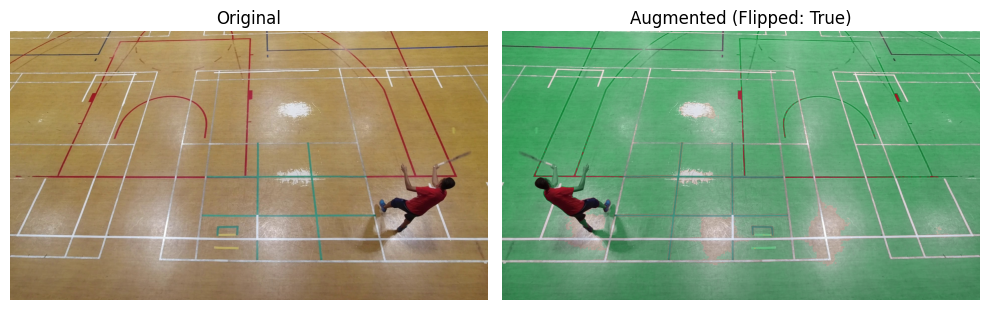

In [ ]:
if train_paths_cnn1:
    try:
        print("\nVisualising augmentation on a sample training image...")
        sample_idx = random.randint(0, len(train_paths_cnn1) - 1)
        sample_path = train_paths_cnn1[sample_idx]
        print(f"Sample path: {sample_path}")
        original_img_bgr = cv2.imread(sample_path)

        if original_img_bgr is not None:
            augmented_img_pil, was_flipped = apply_augmentations(original_img_bgr)
            original_img_rgb = cv2.cvtColor(original_img_bgr, cv2.COLOR_BGR2RGB)
            augmented_img_rgb = np.array(augmented_img_pil) # PIL is RGB

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1); plt.imshow(original_img_rgb); plt.title("Original"); plt.axis('off')
            plt.subplot(1, 2, 2); plt.imshow(augmented_img_rgb); plt.title(f"Augmented (Flipped: {was_flipped})"); plt.axis('off')
            plt.tight_layout(); plt.show()
        else:
            print(f"Warning: Could not load sample image {sample_path}")
    except Exception as e:
        print(f"Error during augmentation visualization: {e}")
else:
    print("No training paths available for augmentation test.")

## Datasets and Dataloaders

### PyTorch Dataset Classes

Defines PyTorch Dataset classes for CNN1 and CNN2 training.

In [ ]:
class TennisFrameDataset(Dataset):
    """Dataset for CNN1 (Hit Frame Regression). Loads single frames."""
    def __init__(self, paths, targets, img_height, img_width, augment=False):
        self.paths = paths; self.targets = targets # Weights for CNN1
        self.img_height = img_height; self.img_width = img_width
        self.augment = augment

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]; target = self.targets[idx]
        try:
            img_bgr = cv2.imread(img_path)
            if img_bgr is None: raise IOError(f"Failed load: {img_path}")
            if self.augment:
                img_pil, _ = apply_augmentations(img_bgr, cnn_type=1)
                img_rgb = np.array(img_pil) # PIL is RGB
            else: img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img_rgb, (self.img_width, self.img_height), interpolation=cv2.INTER_LINEAR)
            img_normalized = (img_resized / 255.0).astype(np.float32)
            img_transposed = np.transpose(img_normalized, (2, 0, 1)) # CHW
            img_tensor = torch.from_numpy(img_transposed)
            target_tensor = torch.tensor(target, dtype=torch.float32)
            return img_tensor, target_tensor
        except Exception as e:
            print(f"Error processing CNN1 image {img_path}: {e}. Returning zeros.")
            dummy_img = torch.zeros((3, self.img_height, self.img_width), dtype=torch.float32)
            dummy_target = torch.tensor(0.0, dtype=torch.float32)
            return dummy_img, dummy_target

class BallLandingDataset(Dataset):
    """Dataset for CNN2 (Landing Spot). Loads frame sequences."""
    def __init__(self, sequence_data, img_height, img_width, n_frames_sequence, augment=False):
        self.sequence_data = sequence_data
        self.img_height = img_height; self.img_width = img_width
        self.n_frames_sequence = n_frames_sequence; self.augment = augment

    def __len__(self): return len(self.sequence_data)

    def __getitem__(self, idx):
        item = self.sequence_data[idx]
        frame_paths = item['sequence_paths']; target_coords = list(item['target_coords']) # Mutable
        sequence_tensors = []; global_flip_status = False
        for i, frame_path in enumerate(frame_paths):
            try:
                img_bgr = cv2.imread(frame_path)
                if img_bgr is None: raise IOError(f"Failed load: {frame_path}")
                if self.augment:
                    img_pil, was_flipped = apply_augmentations(img_bgr, cnn_type=2)
                    img_rgb = np.array(img_pil)
                    if i == 0: global_flip_status = was_flipped # Use first frame's flip status
                else: img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img_rgb, (self.img_width, self.img_height), interpolation=cv2.INTER_LINEAR)
                img_normalized = (img_resized / 255.0).astype(np.float32)
                img_transposed = np.transpose(img_normalized, (2, 0, 1)) # CHW
                sequence_tensors.append(torch.from_numpy(img_transposed))
            except Exception as e:
                print(f"Error processing CNN2 frame {frame_path}: {e}. Using black.")
                sequence_tensors.append(torch.zeros((3, self.img_height, self.img_width), dtype=torch.float32))
                if i == 0: global_flip_status = False # Assume no flip on error
        if global_flip_status: target_coords[0] = 1.0 - target_coords[0] # Flip X coord
        try:
            if len(sequence_tensors) != self.n_frames_sequence: raise ValueError("Incorrect number of frames.")
            # Stack along channel dim: [N, 3, H, W] -> [N*3, H, W]
            stacked_tensor = torch.cat(sequence_tensors, dim=0)
            target_tensor = torch.tensor(target_coords, dtype=torch.float32)
            return stacked_tensor, target_tensor
        except Exception as e:
            print(f"Error stacking/tensorizing CNN2 sequence {idx}: {e}. Returning zeros.")
            dummy_seq = torch.zeros((self.n_frames_sequence * 3, self.img_height, self.img_width), dtype=torch.float32)
            dummy_target = torch.zeros((2,), dtype=torch.float32)
            return dummy_seq, dummy_target

print("Dataset classes defined.")

Dataset classes defined.


### Create Final DataLoaders

In [ ]:
print("Creating Final Datasets and DataLoaders...")
print(f"Using {NUM_WORKERS} workers for DataLoaders.")

# CNN1 DataLoaders (Standard Training)
train_dataset_cnn1 = TennisFrameDataset(train_paths_cnn1, train_weights_cnn1, IMG_HEIGHT, IMG_WIDTH, augment=False) # Augmentation set to false for faster demonstration. Set to True for final train.
val_dataset_cnn1 = TennisFrameDataset(val_paths_cnn1, val_weights_cnn1, IMG_HEIGHT, IMG_WIDTH, augment=False)
test_dataset_cnn1 = TennisFrameDataset(test_paths_cnn1, test_weights_cnn1, IMG_HEIGHT, IMG_WIDTH, augment=False)

train_loader_cnn1 = DataLoader(train_dataset_cnn1, batch_size=CNN1_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=True)
val_loader_cnn1 = DataLoader(val_dataset_cnn1, batch_size=CNN1_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader_cnn1 = DataLoader(test_dataset_cnn1, batch_size=CNN1_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
print(f"CNN1 Loaders: Tr={len(train_loader_cnn1)}, Vl={len(val_loader_cnn1)}, Ts={len(test_loader_cnn1)}")

# CNN2 DataLoaders (Standard Training)
train_loader_cnn2, val_loader_cnn2, test_loader_cnn2 = None, None, None
if train_sequences_cnn2 and val_sequences_cnn2 and test_sequences_cnn2:
    train_dataset_cnn2 = BallLandingDataset(train_sequences_cnn2, IMG_HEIGHT, IMG_WIDTH, CNN2_N_FRAMES_SEQUENCE, augment=False) # Augmentation set to false for faster demonstration. Set to True for final train.
    val_dataset_cnn2 = BallLandingDataset(val_sequences_cnn2, IMG_HEIGHT, IMG_WIDTH, CNN2_N_FRAMES_SEQUENCE, augment=False)
    test_dataset_cnn2 = BallLandingDataset(test_sequences_cnn2, IMG_HEIGHT, IMG_WIDTH, CNN2_N_FRAMES_SEQUENCE, augment=False)

    train_loader_cnn2 = DataLoader(train_dataset_cnn2, batch_size=CNN2_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=True)
    val_loader_cnn2 = DataLoader(val_dataset_cnn2, batch_size=CNN2_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    test_loader_cnn2 = DataLoader(test_dataset_cnn2, batch_size=CNN2_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    print(f"CNN2 Loaders: Tr={len(train_loader_cnn2)}, Vl={len(val_loader_cnn2)}, Ts={len(test_loader_cnn2)}")
else:
    print("Skipping CNN2 DataLoader creation as sequence data is missing.")

Creating Final Datasets and DataLoaders...
Using 2 workers for DataLoaders.
CNN1 Loaders: Tr=412, Vl=52, Ts=52
CNN2 Loaders: Tr=11, Vl=2, Ts=2


### Visualise Sample Batch (CNN1)


Visualising a sample batch from CNN1 Training DataLoader...
Sample batch shape: torch.Size([16, 3, 224, 224])
Sample weights shape: torch.Size([16])


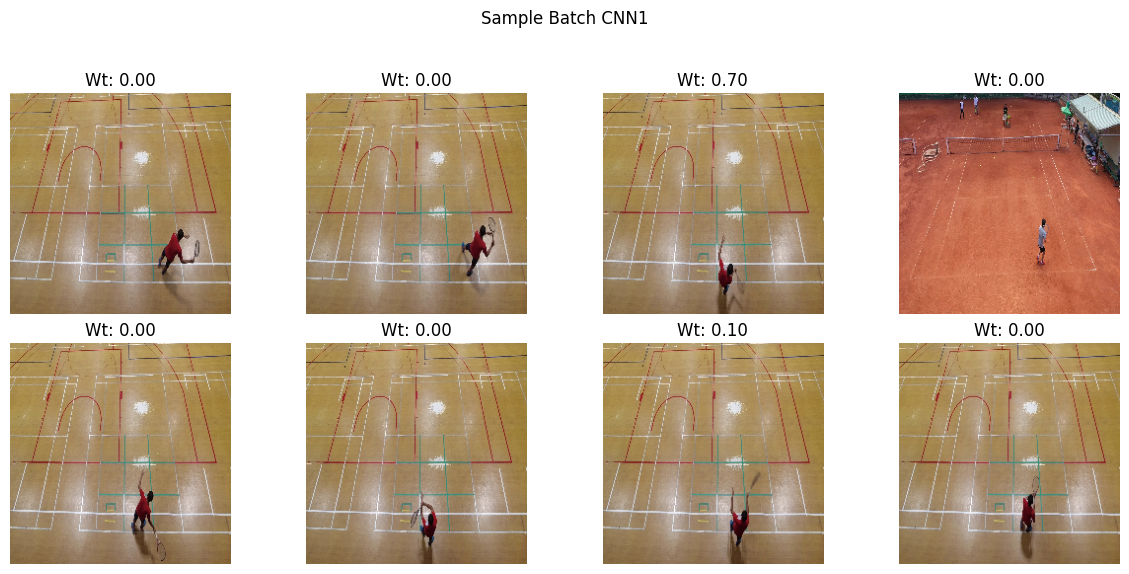

In [ ]:
print("\nVisualising a sample batch from CNN1 Training DataLoader...")
if train_loader_cnn1:
    try:
        sample_images, sample_weights = next(iter(train_loader_cnn1))
        print(f"Sample batch shape: {sample_images.shape}")
        print(f"Sample weights shape: {sample_weights.shape}")

        plt.figure(figsize=(12, 6))
        num_show = min(sample_images.size(0), 8)
        for i in range(num_show):
            plt.subplot(2, 4, i + 1)
            img_display = sample_images[i].numpy().transpose((1, 2, 0))
            img_display = np.clip(img_display, 0, 1)
            plt.imshow(img_display)
            plt.title(f"Wt: {sample_weights[i].item():.2f}")
            plt.axis('off')
        plt.suptitle("Sample Batch CNN1")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
    except StopIteration: print("Could not get batch from CNN1 DataLoader.")
    except Exception as e: print(f"Error visualizing CNN1 batch: {e}")

## Model Architecture

### CNN1: Hit Frame Regressor Final Definition

Defines CNN1 model class using parameters defined in config cell and found with architecture grid search.

In [ ]:
class HitFrameRegressorFinal(nn.Module):
    """Finalized CNN for Hit Frame Regression."""
    def __init__(self, input_channels=3, img_height=IMG_HEIGHT, img_width=IMG_WIDTH,
                 block_filters=CNN1_FILTERS,
                 fc_size=CNN1_FC_SIZE,
                 dropout_rate=CNN1_DROPOUT):
        super().__init__()
        print(f"Initializing HitFrameRegressorFinal:")
        print(f"  - Filters: {block_filters}, FC Size: {fc_size}, Dropout: {dropout_rate}")

        layers = []; current_channels = input_channels
        current_h, current_w = img_height, img_width
        for i, num_filters in enumerate(block_filters):
            layers.extend([
                nn.Conv2d(current_channels, num_filters, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(num_filters), nn.ReLU(inplace=True),
                nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(num_filters), nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            current_channels = num_filters; current_h //= 2; current_w //= 2
        self.conv_blocks = nn.Sequential(*layers)
        flattened_size = current_channels * current_h * current_w
        print(f"  - Final Model Flattened Size: {flattened_size}")
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, fc_size), nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate), nn.Linear(fc_size, 1)
        )
        print(f"  - Final Model FC Block: {flattened_size} -> {fc_size} -> 1")

    def forward(self, x): return self.fc_block(self.conv_blocks(x))

print("HitFrameRegressorFinal model class defined.")

HitFrameRegressorFinal model class defined.


### CNN2: Landing Point Predictor Final Definition

Defines CNN2 model class using parameters defined in config cell and found with architecture grid search.

In [ ]:
class LandingPointCNN(nn.Module):
    """Finalized CNN for Landing Point Prediction."""
    def __init__(self, input_channels, output_dim=2, img_height=IMG_HEIGHT, img_width=IMG_WIDTH,
                 conv_filters=CNN2_CONV_FILTERS,
                 fc_sizes=CNN2_FC_SIZES,
                 dropout_rate=CNN2_DROPOUT):
        super().__init__()
        print(f"Initializing LandingPointCNN:")
        print(f"  - Input Channels: {input_channels}")
        print(f"  - Conv Filters: {conv_filters}")
        print(f"  - FC Sizes: {fc_sizes}")
        print(f"  - Dropout: {dropout_rate}")

        current_h, current_w = img_height, img_width
        conv_layers = []; current_c = input_channels
        block_configs = [
            {'k': 7, 's': 2, 'p': 3, 'pool_k': 3, 'pool_s': 2, 'pool_p': 1},
            {'k': 5, 's': 1, 'p': 2, 'pool_k': 3, 'pool_s': 2, 'pool_p': 1},
            {'k': 3, 's': 1, 'p': 1, 'pool_k': 3, 'pool_s': 2, 'pool_p': 1},
            {'k': 3, 's': 1, 'p': 1, 'pool_k': 3, 'pool_s': 2, 'pool_p': 1} ]
        num_blocks = len(conv_filters)
        for i in range(num_blocks):
            out_c = conv_filters[i]; cfg = block_configs[min(i, len(block_configs)-1)]
            conv_layers.extend([
                nn.Conv2d(current_c, out_c, kernel_size=cfg['k'], stride=cfg['s'], padding=cfg['p'], bias=False),
                nn.BatchNorm2d(out_c), nn.ReLU(inplace=True) ])
            current_h=(current_h + 2*cfg['p'] - cfg['k']) // cfg['s'] + 1
            current_w=(current_w + 2*cfg['p'] - cfg['k']) // cfg['s'] + 1
            conv_layers.append(nn.MaxPool2d(kernel_size=cfg['pool_k'], stride=cfg['pool_s'], padding=cfg['pool_p']))
            current_h=(current_h + 2*cfg['pool_p'] - cfg['pool_k']) // cfg['pool_s'] + 1
            current_w=(current_w + 2*cfg['pool_p'] - cfg['pool_k']) // cfg['pool_s'] + 1
            current_c = out_c
        self.conv_blocks = nn.Sequential(*conv_layers)
        flattened_size = current_c * current_h * current_w
        print(f"  - Final CNN2 Flattened size: {flattened_size} ({current_c}x{current_h}x{current_w})")
        fc_layers = [nn.Flatten()]; last_size = flattened_size
        for size in fc_sizes:
            fc_layers.extend([nn.Linear(last_size, size), nn.ReLU(inplace=True), nn.Dropout(dropout_rate)])
            last_size = size
        fc_layers.extend([nn.Linear(last_size, output_dim), nn.Sigmoid()])
        self.fc_block = nn.Sequential(*fc_layers)
        print(f"  - Final CNN2 FC block built.")

    def forward(self, x): return self.fc_block(self.conv_blocks(x))

print("LandingPointCNN model class defined.")

LandingPointCNN model class defined.


## Final Model Training

### Training Function (with Early Stopping)

Defines final training function for both models.

In [ ]:
def run_final_training(model, model_name, train_loader, val_loader, criterion, optimizer, device,
                       epochs, patience, min_improvement, results_save_path, best_model_save_path):
    """Trains a model with early stopping, saves best model and history."""
    start_time = time.time()
    history = {'train_loss': [], 'val_loss': [], 'val_mae': []}
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_epoch = 0

    # Ensure save directories exist
    os.makedirs(os.path.dirname(best_model_save_path), exist_ok=True)
    os.makedirs(os.path.dirname(results_save_path), exist_ok=True)

    print(f"\n--- Starting Final Training ({model_name}) for max {epochs} epochs ---")
    print(f"Early stopping: Patience={patience}, Min Improvement={min_improvement}")

    for epoch in range(epochs):
        epoch_start_time = time.time()
        # --- Training Phase ---
        model.train(); running_train_loss = 0.0; non_blocking = device.type == 'cuda'
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False, ncols=80)
        for inputs, targets in train_loop:
            inputs = inputs.to(device, non_blocking=non_blocking)
            targets = targets.to(device, non_blocking=non_blocking)
            is_cnn1 = model_name.startswith("CNN1")
            if is_cnn1: targets = targets.view(-1, 1).float() # CNN1 needs [B, 1]
            else: targets = targets.view(-1, 2).float() # CNN2 needs [B, 2]
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward(); optimizer.step()
            running_train_loss += loss.item()
            train_loop.set_postfix(loss=f"{loss.item():.5f}")
        epoch_train_loss = running_train_loss / len(train_loader) if len(train_loader) > 0 else 0.0
        history['train_loss'].append(epoch_train_loss)
        train_loop.close()

        # --- Validation Phase ---
        model.eval(); running_val_loss = 0.0; running_val_mae = 0.0
        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False, ncols=80)
        with torch.no_grad():
            for inputs, targets in val_loop:
                inputs = inputs.to(device, non_blocking=non_blocking)
                targets = targets.to(device, non_blocking=non_blocking)
                if is_cnn1: targets = targets.view(-1, 1).float()
                else: targets = targets.view(-1, 2).float()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
                mae = torch.abs(outputs - targets).mean()
                running_val_mae += mae.item()
                val_loop.set_postfix(loss=f"{loss.item():.5f}", mae=f"{mae.item():.4f}")
        epoch_val_loss = running_val_loss / len(val_loader) if len(val_loader) > 0 else float('inf')
        epoch_val_mae = running_val_mae / len(val_loader) if len(val_loader) > 0 else float('inf')
        history['val_loss'].append(epoch_val_loss)
        history['val_mae'].append(epoch_val_mae)
        val_loop.close()
        epoch_duration = time.time() - epoch_start_time

        print(f"Epoch {epoch+1}/{epochs} ({model_name}) | Train Loss: {epoch_train_loss:.5f} | Val Loss: {epoch_val_loss:.5f} | Val MAE: {epoch_val_mae:.4f} | Time: {epoch_duration:.2f}s")

        # --- Early Stopping & Best Model Saving ---
        if epoch_val_loss < best_val_loss - min_improvement:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0; best_epoch = epoch + 1
            try: torch.save(model.state_dict(), best_model_save_path)
            except Exception as e: print(f" Error saving best model: {e}")
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best Val Loss: {best_val_loss:.6f} at epoch {best_epoch}.")
            if os.path.exists(best_model_save_path):
                 try: model.load_state_dict(torch.load(best_model_save_path, map_location=device)); print("Loaded best weights.")
                 except Exception as e: print(f" Error loading best weights: {e}")
            break

    total_time = time.time() - start_time
    print(f"--- Training ({model_name}) finished in {total_time:.2f} seconds ---")
    if best_epoch > 0: print(f"Best epoch: {best_epoch}, Best Val Loss: {best_val_loss:.6f}")

    # Save history
    try: pd.DataFrame(history).to_csv(results_save_path, index_label='epoch'); print(f"History saved: {results_save_path}")
    except Exception as e: print(f" Error saving history: {e}")
    return history

print("Final training function defined.")

Final training function defined.


### Train Final CNN1 Model

Runs training for CNN1 HitFrameRegressor.

In [ ]:
if train_loader_cnn1 and val_loader_cnn1:
    print("\n--- Training Final CNN1 Model ---")
    # Instantiate final CNN1
    cnn1_model_final = HitFrameRegressorFinal().to(DEVICE)
    cnn1_criterion = nn.MSELoss()
    cnn1_optimizer = optim.Adam(cnn1_model_final.parameters(), lr=CNN1_LEARNING_RATE)
    cnn1_model_path = os.path.join(project_path, 'cnn1_hit_frame_regressor_final.pth')
    cnn1_history_path = os.path.join(project_path, 'cnn1_final_training_history.csv')

    cnn1_history = run_final_training(
        model=cnn1_model_final, model_name="CNN1 Final",
        train_loader=train_loader_cnn1, val_loader=val_loader_cnn1,
        criterion=cnn1_criterion, optimizer=cnn1_optimizer, device=DEVICE,
        epochs=FINAL_TRAINING_EPOCHS, patience=EARLY_STOPPING_PATIENCE,
        min_improvement=MIN_IMPROVEMENT,
        results_save_path=cnn1_history_path, best_model_save_path=cnn1_model_path
    )
    del cnn1_model_final, cnn1_optimizer, cnn1_criterion; gc.collect(); torch.cuda.empty_cache()
else:
    print("Skipping CNN1 final training: DataLoaders not available.")


--- Training Final CNN1 Model ---
Initializing HitFrameRegressorFinal:
  - Filters: (32, 32, 64, 64), FC Size: 512, Dropout: 0.5
  - Final Model Flattened Size: 12544
  - Final Model FC Block: 12544 -> 512 -> 1

--- Starting Final Training (CNN1 Final) for max 50 epochs ---
Early stopping: Patience=15, Min Improvement=1e-05


Epoch 1/50 [Train]:   0%|                               | 0/412 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|                                  | 0/52 [00:00<?, ?it/s]

Epoch 1/50 (CNN1 Final) | Train Loss: 0.69942 | Val Loss: 0.06749 | Val MAE: 0.1651 | Time: 124.91s
 Error saving best model: File /kaggle/input/st311-tennis/cnn1_hit_frame_regressor_final.pth cannot be opened.


Epoch 2/50 [Train]:   0%|                               | 0/412 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|                                  | 0/52 [00:00<?, ?it/s]

Epoch 2/50 (CNN1 Final) | Train Loss: 0.05547 | Val Loss: 0.06665 | Val MAE: 0.1623 | Time: 111.28s
 Error saving best model: File /kaggle/input/st311-tennis/cnn1_hit_frame_regressor_final.pth cannot be opened.


Epoch 3/50 [Train]:   0%|                               | 0/412 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|                                  | 0/52 [00:00<?, ?it/s]

Epoch 3/50 (CNN1 Final) | Train Loss: 0.05468 | Val Loss: 0.06702 | Val MAE: 0.1599 | Time: 108.66s


Epoch 4/50 [Train]:   0%|                               | 0/412 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|                                  | 0/52 [00:00<?, ?it/s]

Epoch 4/50 (CNN1 Final) | Train Loss: 0.05434 | Val Loss: 0.06499 | Val MAE: 0.1667 | Time: 109.21s
 Error saving best model: File /kaggle/input/st311-tennis/cnn1_hit_frame_regressor_final.pth cannot be opened.


Epoch 5/50 [Train]:   0%|                               | 0/412 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|                                  | 0/52 [00:00<?, ?it/s]

Epoch 5/50 (CNN1 Final) | Train Loss: 0.05271 | Val Loss: 0.06281 | Val MAE: 0.1498 | Time: 110.94s
 Error saving best model: File /kaggle/input/st311-tennis/cnn1_hit_frame_regressor_final.pth cannot be opened.


Epoch 6/50 [Train]:   0%|                               | 0/412 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|                                  | 0/52 [00:00<?, ?it/s]

Epoch 6/50 (CNN1 Final) | Train Loss: 0.05038 | Val Loss: 0.07614 | Val MAE: 0.2349 | Time: 108.99s


Epoch 7/50 [Train]:   0%|                               | 0/412 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|                                  | 0/52 [00:00<?, ?it/s]

Epoch 7/50 (CNN1 Final) | Train Loss: 0.04488 | Val Loss: 0.04295 | Val MAE: 0.1307 | Time: 109.24s
 Error saving best model: File /kaggle/input/st311-tennis/cnn1_hit_frame_regressor_final.pth cannot be opened.


Epoch 8/50 [Train]:   0%|                               | 0/412 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|                                  | 0/52 [00:00<?, ?it/s]

Epoch 8/50 (CNN1 Final) | Train Loss: 0.04354 | Val Loss: 0.04783 | Val MAE: 0.1671 | Time: 107.20s


Epoch 9/50 [Train]:   0%|                               | 0/412 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|                                  | 0/52 [00:00<?, ?it/s]

Epoch 9/50 (CNN1 Final) | Train Loss: 0.03642 | Val Loss: 0.07702 | Val MAE: 0.1117 | Time: 108.51s


Epoch 10/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 10/50 (CNN1 Final) | Train Loss: 0.03609 | Val Loss: 0.07295 | Val MAE: 0.1227 | Time: 107.44s


Epoch 11/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 11/50 (CNN1 Final) | Train Loss: 0.03213 | Val Loss: 0.03633 | Val MAE: 0.1006 | Time: 109.40s
 Error saving best model: File /kaggle/input/st311-tennis/cnn1_hit_frame_regressor_final.pth cannot be opened.


Epoch 12/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 12/50 (CNN1 Final) | Train Loss: 0.03084 | Val Loss: 0.03438 | Val MAE: 0.0949 | Time: 109.82s
 Error saving best model: File /kaggle/input/st311-tennis/cnn1_hit_frame_regressor_final.pth cannot be opened.


Epoch 13/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 13/50 (CNN1 Final) | Train Loss: 0.03121 | Val Loss: 0.07967 | Val MAE: 0.2161 | Time: 108.06s


Epoch 14/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 14/50 (CNN1 Final) | Train Loss: 0.02721 | Val Loss: 0.02664 | Val MAE: 0.0987 | Time: 109.37s
 Error saving best model: File /kaggle/input/st311-tennis/cnn1_hit_frame_regressor_final.pth cannot be opened.


Epoch 15/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 15/50 (CNN1 Final) | Train Loss: 0.02898 | Val Loss: 0.02343 | Val MAE: 0.0960 | Time: 108.52s
 Error saving best model: File /kaggle/input/st311-tennis/cnn1_hit_frame_regressor_final.pth cannot be opened.


Epoch 16/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 16/50 (CNN1 Final) | Train Loss: 0.02767 | Val Loss: 0.03147 | Val MAE: 0.1195 | Time: 109.42s


Epoch 17/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 17/50 (CNN1 Final) | Train Loss: 0.02623 | Val Loss: 0.02095 | Val MAE: 0.0733 | Time: 106.59s
 Error saving best model: File /kaggle/input/st311-tennis/cnn1_hit_frame_regressor_final.pth cannot be opened.


Epoch 18/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 18/50 (CNN1 Final) | Train Loss: 0.02578 | Val Loss: 0.02101 | Val MAE: 0.0959 | Time: 105.07s


Epoch 19/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 19/50 (CNN1 Final) | Train Loss: 0.02615 | Val Loss: 0.02382 | Val MAE: 0.0725 | Time: 106.81s


Epoch 20/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 20/50 (CNN1 Final) | Train Loss: 0.02397 | Val Loss: 0.02147 | Val MAE: 0.0748 | Time: 104.75s


Epoch 21/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 21/50 (CNN1 Final) | Train Loss: 0.02679 | Val Loss: 0.03153 | Val MAE: 0.0818 | Time: 104.93s


Epoch 22/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 22/50 (CNN1 Final) | Train Loss: 0.02182 | Val Loss: 0.02713 | Val MAE: 0.0964 | Time: 107.43s


Epoch 23/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 23/50 (CNN1 Final) | Train Loss: 0.02180 | Val Loss: 0.01776 | Val MAE: 0.0687 | Time: 108.20s
 Error saving best model: File /kaggle/input/st311-tennis/cnn1_hit_frame_regressor_final.pth cannot be opened.


Epoch 24/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 24/50 (CNN1 Final) | Train Loss: 0.01972 | Val Loss: 0.01897 | Val MAE: 0.0656 | Time: 109.14s


Epoch 25/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 25/50 (CNN1 Final) | Train Loss: 0.02013 | Val Loss: 0.01892 | Val MAE: 0.0620 | Time: 110.73s


Epoch 26/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 26/50 (CNN1 Final) | Train Loss: 0.02107 | Val Loss: 0.03006 | Val MAE: 0.1343 | Time: 109.62s


Epoch 27/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 27/50 (CNN1 Final) | Train Loss: 0.01834 | Val Loss: 0.02553 | Val MAE: 0.0679 | Time: 108.85s


Epoch 28/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 28/50 (CNN1 Final) | Train Loss: 0.01658 | Val Loss: 0.01705 | Val MAE: 0.0664 | Time: 108.29s
 Error saving best model: File /kaggle/input/st311-tennis/cnn1_hit_frame_regressor_final.pth cannot be opened.


Epoch 29/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 29/50 (CNN1 Final) | Train Loss: 0.01596 | Val Loss: 0.01517 | Val MAE: 0.0551 | Time: 109.85s
 Error saving best model: File /kaggle/input/st311-tennis/cnn1_hit_frame_regressor_final.pth cannot be opened.


Epoch 30/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 30/50 (CNN1 Final) | Train Loss: 0.01400 | Val Loss: 0.03288 | Val MAE: 0.0707 | Time: 109.20s


Epoch 31/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 31/50 (CNN1 Final) | Train Loss: 0.01338 | Val Loss: 0.01636 | Val MAE: 0.0536 | Time: 107.99s


Epoch 32/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 32/50 (CNN1 Final) | Train Loss: 0.01254 | Val Loss: 0.02077 | Val MAE: 0.0625 | Time: 106.95s


Epoch 33/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 33/50 (CNN1 Final) | Train Loss: 0.01174 | Val Loss: 0.01499 | Val MAE: 0.0602 | Time: 109.51s
 Error saving best model: File /kaggle/input/st311-tennis/cnn1_hit_frame_regressor_final.pth cannot be opened.


Epoch 34/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 34/50 (CNN1 Final) | Train Loss: 0.01082 | Val Loss: 0.01848 | Val MAE: 0.0691 | Time: 107.04s


Epoch 35/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 35/50 (CNN1 Final) | Train Loss: 0.01123 | Val Loss: 0.03071 | Val MAE: 0.1002 | Time: 110.25s


Epoch 36/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 36/50 (CNN1 Final) | Train Loss: 0.01041 | Val Loss: 0.01419 | Val MAE: 0.0502 | Time: 107.84s
 Error saving best model: File /kaggle/input/st311-tennis/cnn1_hit_frame_regressor_final.pth cannot be opened.


Epoch 37/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 37/50 (CNN1 Final) | Train Loss: 0.00950 | Val Loss: 0.01521 | Val MAE: 0.0593 | Time: 110.16s


Epoch 38/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 38/50 (CNN1 Final) | Train Loss: 0.00965 | Val Loss: 0.01595 | Val MAE: 0.0499 | Time: 109.08s


Epoch 39/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 39/50 (CNN1 Final) | Train Loss: 0.00912 | Val Loss: 0.02010 | Val MAE: 0.0570 | Time: 111.96s


Epoch 40/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 40/50 (CNN1 Final) | Train Loss: 0.00864 | Val Loss: 0.01668 | Val MAE: 0.0523 | Time: 111.52s


Epoch 41/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 41/50 (CNN1 Final) | Train Loss: 0.00742 | Val Loss: 0.02088 | Val MAE: 0.0821 | Time: 108.75s


Epoch 42/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 42/50 (CNN1 Final) | Train Loss: 0.00835 | Val Loss: 0.01705 | Val MAE: 0.0578 | Time: 111.52s


Epoch 43/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 43/50 (CNN1 Final) | Train Loss: 0.00685 | Val Loss: 0.01219 | Val MAE: 0.0452 | Time: 109.12s
 Error saving best model: File /kaggle/input/st311-tennis/cnn1_hit_frame_regressor_final.pth cannot be opened.


Epoch 44/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 44/50 (CNN1 Final) | Train Loss: 0.00666 | Val Loss: 0.01575 | Val MAE: 0.0482 | Time: 110.70s


Epoch 45/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 45/50 (CNN1 Final) | Train Loss: 0.00657 | Val Loss: 0.01599 | Val MAE: 0.0504 | Time: 110.02s


Epoch 46/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 46/50 (CNN1 Final) | Train Loss: 0.00656 | Val Loss: 0.01451 | Val MAE: 0.0527 | Time: 108.21s


Epoch 47/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 47/50 (CNN1 Final) | Train Loss: 0.00543 | Val Loss: 0.01290 | Val MAE: 0.0456 | Time: 110.61s


Epoch 48/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 48/50 (CNN1 Final) | Train Loss: 0.00589 | Val Loss: 0.01286 | Val MAE: 0.0497 | Time: 109.07s


Epoch 49/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 49/50 (CNN1 Final) | Train Loss: 0.00596 | Val Loss: 0.01359 | Val MAE: 0.0480 | Time: 111.85s


Epoch 50/50 [Train]:   0%|                              | 0/412 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|                                 | 0/52 [00:00<?, ?it/s]

Epoch 50/50 (CNN1 Final) | Train Loss: 0.00611 | Val Loss: 0.01447 | Val MAE: 0.0562 | Time: 111.36s
--- Training (CNN1 Final) finished in 5464.00 seconds ---
Best epoch: 43, Best Val Loss: 0.012186
 Error saving history: [Errno 30] Read-only file system: '/kaggle/input/st311-tennis/cnn1_final_training_history.csv'


### Train Final CNN2 Model

Runs training for CNN2 LandingPointCNN.

In [ ]:
if train_loader_cnn2 and val_loader_cnn2:
    print("\n--- Training Final CNN2 Model ---")
    # Instantiate final CNN2
    cnn2_input_channels = CNN2_N_FRAMES_SEQUENCE * 3
    cnn2_model_final = LandingPointCNN(input_channels=cnn2_input_channels).to(DEVICE)
    cnn2_criterion = nn.MSELoss()
    cnn2_optimizer = optim.Adam(cnn2_model_final.parameters(), lr=CNN2_LEARNING_RATE)
    cnn2_model_path = os.path.join(project_path, 'cnn2_landing_spot_predictor_final.pth')
    cnn2_history_path = os.path.join(project_path, 'cnn2_final_training_history.csv')

    cnn2_history = run_final_training(
        model=cnn2_model_final, model_name="CNN2 Final",
        train_loader=train_loader_cnn2, val_loader=val_loader_cnn2,
        criterion=cnn2_criterion, optimizer=cnn2_optimizer, device=DEVICE,
        epochs=FINAL_TRAINING_EPOCHS, patience=EARLY_STOPPING_PATIENCE,
        min_improvement=MIN_IMPROVEMENT,
        results_save_path=cnn2_history_path, best_model_save_path=cnn2_model_path
    )
    del cnn2_model_final, cnn2_optimizer, cnn2_criterion; gc.collect(); torch.cuda.empty_cache()
else:
    print("Skipping CNN2 final training: DataLoaders not available.")


--- Training Final CNN2 Model ---
Initializing LandingPointCNN:
  - Input Channels: 27
  - Conv Filters: (128, 256, 512, 512)
  - FC Sizes: (512, 256)
  - Dropout: 0.5
  - Final CNN2 Flattened size: 25088 (512x7x7)
  - Final CNN2 FC block built.

--- Starting Final Training (CNN2 Final) for max 50 epochs ---
Early stopping: Patience=15, Min Improvement=1e-05


Epoch 1/50 [Train]:   0%|                                | 0/11 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|                                   | 0/2 [00:00<?, ?it/s]

Epoch 1/50 (CNN2 Final) | Train Loss: 0.06971 | Val Loss: 0.06423 | Val MAE: 0.2266 | Time: 28.90s
 Error saving best model: File /kaggle/input/st311-tennis/cnn2_landing_spot_predictor_final.pth cannot be opened.


Epoch 2/50 [Train]:   0%|                                | 0/11 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|                                   | 0/2 [00:00<?, ?it/s]

Epoch 2/50 (CNN2 Final) | Train Loss: 0.05308 | Val Loss: 0.06341 | Val MAE: 0.2243 | Time: 26.22s
 Error saving best model: File /kaggle/input/st311-tennis/cnn2_landing_spot_predictor_final.pth cannot be opened.


Epoch 3/50 [Train]:   0%|                                | 0/11 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|                                   | 0/2 [00:00<?, ?it/s]

Epoch 3/50 (CNN2 Final) | Train Loss: 0.03610 | Val Loss: 0.05354 | Val MAE: 0.2052 | Time: 26.44s
 Error saving best model: File /kaggle/input/st311-tennis/cnn2_landing_spot_predictor_final.pth cannot be opened.


Epoch 4/50 [Train]:   0%|                                | 0/11 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|                                   | 0/2 [00:00<?, ?it/s]

Epoch 4/50 (CNN2 Final) | Train Loss: 0.02618 | Val Loss: 0.03914 | Val MAE: 0.1652 | Time: 26.61s
 Error saving best model: File /kaggle/input/st311-tennis/cnn2_landing_spot_predictor_final.pth cannot be opened.


Epoch 5/50 [Train]:   0%|                                | 0/11 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|                                   | 0/2 [00:00<?, ?it/s]

Epoch 5/50 (CNN2 Final) | Train Loss: 0.02110 | Val Loss: 0.02959 | Val MAE: 0.1321 | Time: 26.71s
 Error saving best model: File /kaggle/input/st311-tennis/cnn2_landing_spot_predictor_final.pth cannot be opened.


Epoch 6/50 [Train]:   0%|                                | 0/11 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|                                   | 0/2 [00:00<?, ?it/s]

Epoch 6/50 (CNN2 Final) | Train Loss: 0.02212 | Val Loss: 0.02181 | Val MAE: 0.1106 | Time: 26.33s
 Error saving best model: File /kaggle/input/st311-tennis/cnn2_landing_spot_predictor_final.pth cannot be opened.


Epoch 7/50 [Train]:   0%|                                | 0/11 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|                                   | 0/2 [00:00<?, ?it/s]

Epoch 7/50 (CNN2 Final) | Train Loss: 0.02204 | Val Loss: 0.02368 | Val MAE: 0.1143 | Time: 26.15s


Epoch 8/50 [Train]:   0%|                                | 0/11 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|                                   | 0/2 [00:00<?, ?it/s]

Epoch 8/50 (CNN2 Final) | Train Loss: 0.02045 | Val Loss: 0.02378 | Val MAE: 0.1130 | Time: 25.96s


Epoch 9/50 [Train]:   0%|                                | 0/11 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|                                   | 0/2 [00:00<?, ?it/s]

Epoch 9/50 (CNN2 Final) | Train Loss: 0.01953 | Val Loss: 0.02091 | Val MAE: 0.1091 | Time: 25.90s
 Error saving best model: File /kaggle/input/st311-tennis/cnn2_landing_spot_predictor_final.pth cannot be opened.


Epoch 10/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 10/50 (CNN2 Final) | Train Loss: 0.02169 | Val Loss: 0.02342 | Val MAE: 0.1141 | Time: 26.02s


Epoch 11/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 11/50 (CNN2 Final) | Train Loss: 0.01904 | Val Loss: 0.02109 | Val MAE: 0.1081 | Time: 26.16s


Epoch 12/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 12/50 (CNN2 Final) | Train Loss: 0.01763 | Val Loss: 0.02208 | Val MAE: 0.1109 | Time: 26.19s


Epoch 13/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 13/50 (CNN2 Final) | Train Loss: 0.01808 | Val Loss: 0.02085 | Val MAE: 0.1074 | Time: 26.36s
 Error saving best model: File /kaggle/input/st311-tennis/cnn2_landing_spot_predictor_final.pth cannot be opened.


Epoch 14/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 14/50 (CNN2 Final) | Train Loss: 0.01796 | Val Loss: 0.02229 | Val MAE: 0.1101 | Time: 26.28s


Epoch 15/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 15/50 (CNN2 Final) | Train Loss: 0.01592 | Val Loss: 0.02083 | Val MAE: 0.1061 | Time: 26.42s
 Error saving best model: File /kaggle/input/st311-tennis/cnn2_landing_spot_predictor_final.pth cannot be opened.


Epoch 16/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 16/50 (CNN2 Final) | Train Loss: 0.01564 | Val Loss: 0.02381 | Val MAE: 0.1176 | Time: 26.47s


Epoch 17/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 17/50 (CNN2 Final) | Train Loss: 0.01711 | Val Loss: 0.02145 | Val MAE: 0.1086 | Time: 26.95s


Epoch 18/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 18/50 (CNN2 Final) | Train Loss: 0.01384 | Val Loss: 0.02199 | Val MAE: 0.1092 | Time: 26.27s


Epoch 19/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 19/50 (CNN2 Final) | Train Loss: 0.01650 | Val Loss: 0.02094 | Val MAE: 0.1110 | Time: 26.12s


Epoch 20/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 20/50 (CNN2 Final) | Train Loss: 0.01517 | Val Loss: 0.02441 | Val MAE: 0.1133 | Time: 26.24s


Epoch 21/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 21/50 (CNN2 Final) | Train Loss: 0.01526 | Val Loss: 0.02148 | Val MAE: 0.1160 | Time: 26.08s


Epoch 22/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 22/50 (CNN2 Final) | Train Loss: 0.01392 | Val Loss: 0.02367 | Val MAE: 0.1086 | Time: 25.75s


Epoch 23/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 23/50 (CNN2 Final) | Train Loss: 0.01440 | Val Loss: 0.02085 | Val MAE: 0.1098 | Time: 25.89s


Epoch 24/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 24/50 (CNN2 Final) | Train Loss: 0.01264 | Val Loss: 0.02023 | Val MAE: 0.1045 | Time: 26.11s
 Error saving best model: File /kaggle/input/st311-tennis/cnn2_landing_spot_predictor_final.pth cannot be opened.


Epoch 25/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 25/50 (CNN2 Final) | Train Loss: 0.01432 | Val Loss: 0.02188 | Val MAE: 0.1084 | Time: 26.38s


Epoch 26/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 26/50 (CNN2 Final) | Train Loss: 0.01311 | Val Loss: 0.01858 | Val MAE: 0.0991 | Time: 26.12s
 Error saving best model: File /kaggle/input/st311-tennis/cnn2_landing_spot_predictor_final.pth cannot be opened.


Epoch 27/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 27/50 (CNN2 Final) | Train Loss: 0.01330 | Val Loss: 0.01861 | Val MAE: 0.0967 | Time: 26.24s


Epoch 28/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 28/50 (CNN2 Final) | Train Loss: 0.01356 | Val Loss: 0.02164 | Val MAE: 0.1002 | Time: 26.42s


Epoch 29/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 29/50 (CNN2 Final) | Train Loss: 0.01107 | Val Loss: 0.01748 | Val MAE: 0.0938 | Time: 26.70s
 Error saving best model: File /kaggle/input/st311-tennis/cnn2_landing_spot_predictor_final.pth cannot be opened.


Epoch 30/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 30/50 (CNN2 Final) | Train Loss: 0.01226 | Val Loss: 0.01788 | Val MAE: 0.0978 | Time: 26.87s


Epoch 31/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 31/50 (CNN2 Final) | Train Loss: 0.01258 | Val Loss: 0.01896 | Val MAE: 0.0996 | Time: 25.93s


Epoch 32/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 32/50 (CNN2 Final) | Train Loss: 0.01315 | Val Loss: 0.02044 | Val MAE: 0.1003 | Time: 26.25s


Epoch 33/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 33/50 (CNN2 Final) | Train Loss: 0.01159 | Val Loss: 0.01931 | Val MAE: 0.0961 | Time: 26.15s


Epoch 34/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 34/50 (CNN2 Final) | Train Loss: 0.01139 | Val Loss: 0.02308 | Val MAE: 0.1149 | Time: 25.81s


Epoch 35/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 35/50 (CNN2 Final) | Train Loss: 0.01172 | Val Loss: 0.01772 | Val MAE: 0.0954 | Time: 25.88s


Epoch 36/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 36/50 (CNN2 Final) | Train Loss: 0.01093 | Val Loss: 0.01852 | Val MAE: 0.0957 | Time: 26.20s


Epoch 37/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 37/50 (CNN2 Final) | Train Loss: 0.01087 | Val Loss: 0.01662 | Val MAE: 0.0933 | Time: 26.46s
 Error saving best model: File /kaggle/input/st311-tennis/cnn2_landing_spot_predictor_final.pth cannot be opened.


Epoch 38/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 38/50 (CNN2 Final) | Train Loss: 0.01094 | Val Loss: 0.01960 | Val MAE: 0.1019 | Time: 26.36s


Epoch 39/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 39/50 (CNN2 Final) | Train Loss: 0.01174 | Val Loss: 0.02181 | Val MAE: 0.1110 | Time: 26.47s


Epoch 40/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 40/50 (CNN2 Final) | Train Loss: 0.01072 | Val Loss: 0.02225 | Val MAE: 0.1141 | Time: 26.43s


Epoch 41/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 41/50 (CNN2 Final) | Train Loss: 0.01119 | Val Loss: 0.02059 | Val MAE: 0.1064 | Time: 26.42s


Epoch 42/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 42/50 (CNN2 Final) | Train Loss: 0.01204 | Val Loss: 0.01865 | Val MAE: 0.0993 | Time: 26.57s


Epoch 43/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 43/50 (CNN2 Final) | Train Loss: 0.01087 | Val Loss: 0.01966 | Val MAE: 0.1007 | Time: 26.51s


Epoch 44/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 44/50 (CNN2 Final) | Train Loss: 0.01118 | Val Loss: 0.01977 | Val MAE: 0.1006 | Time: 26.36s


Epoch 45/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 45/50 (CNN2 Final) | Train Loss: 0.00987 | Val Loss: 0.01806 | Val MAE: 0.0951 | Time: 26.08s


Epoch 46/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 46/50 (CNN2 Final) | Train Loss: 0.00940 | Val Loss: 0.02019 | Val MAE: 0.1029 | Time: 25.80s


Epoch 47/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 47/50 (CNN2 Final) | Train Loss: 0.01052 | Val Loss: 0.01984 | Val MAE: 0.1031 | Time: 25.89s


Epoch 48/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 48/50 (CNN2 Final) | Train Loss: 0.01018 | Val Loss: 0.01869 | Val MAE: 0.0992 | Time: 26.23s


Epoch 49/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 49/50 (CNN2 Final) | Train Loss: 0.00988 | Val Loss: 0.01939 | Val MAE: 0.0947 | Time: 26.24s


Epoch 50/50 [Train]:   0%|                               | 0/11 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|                                  | 0/2 [00:00<?, ?it/s]

Epoch 50/50 (CNN2 Final) | Train Loss: 0.01067 | Val Loss: 0.02304 | Val MAE: 0.1066 | Time: 26.27s
--- Training (CNN2 Final) finished in 1315.59 seconds ---
Best epoch: 37, Best Val Loss: 0.016621
 Error saving history: [Errno 30] Read-only file system: '/kaggle/input/st311-tennis/cnn2_final_training_history.csv'


## Evaluation

### Evaluation Function

In [ ]:
def evaluate_model(model, model_name, test_loader, criterion, device):
    """Evaluates a model on the test set."""
    print(f"\n--- Evaluating Model ({model_name}) on Test Set ---")
    if not test_loader: print(" Test loader not available. Skipping."); return None
    model.eval(); running_test_loss = 0.0; running_test_mae = 0.0
    non_blocking = device.type == 'cuda'
    results_list = []
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc=f"Testing ({model_name})", leave=False):
            inputs = inputs.to(device, non_blocking=non_blocking)
            targets = targets.to(device, non_blocking=non_blocking)
            is_cnn1 = model_name.startswith("CNN1")
            if is_cnn1: targets = targets.view(-1, 1).float()
            else: targets = targets.view(-1, 2).float()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_test_loss += loss.item()
            mae = torch.abs(outputs - targets).mean()
            running_test_mae += mae.item()
    test_loss = running_test_loss / len(test_loader) if len(test_loader) > 0 else float('nan')
    test_mae = running_test_mae / len(test_loader) if len(test_loader) > 0 else float('nan')
    print(f"Test Results ({model_name}): Loss (MSE)={test_loss:.6f}, MAE={test_mae:.4f}")
    return {'test_loss': test_loss, 'test_mae': test_mae}

print("Evaluation function defined.")

Evaluation function defined.


### Evaluate Final Models

In [ ]:
cnn1_test_results, cnn2_test_results = None, None

# --- Evaluate CNN1 ---
cnn1_model_path = os.path.join(project_path, 'cnn1_hit_frame_regressor_final.pth')
if os.path.exists(cnn1_model_path) and test_loader_cnn1:
    print("\nEvaluating CNN1...")
    cnn1_model_eval = HitFrameRegressorFinal().to(DEVICE) # Instantiate with final arch
    try:
        cnn1_model_eval.load_state_dict(torch.load(cnn1_model_path, map_location=DEVICE))
        cnn1_test_results = evaluate_model(cnn1_model_eval, "CNN1 Final", test_loader_cnn1, nn.MSELoss(), DEVICE)
        del cnn1_model_eval # Clean up
    except Exception as e: print(f" Failed to load/evaluate CNN1: {e}")
else: print("\nSkipping CNN1 evaluation (model file or test loader not found).")

# --- Evaluate CNN2 ---
cnn2_model_path = os.path.join(project_path, 'cnn2_landing_spot_predictor_final.pth')
if os.path.exists(cnn2_model_path) and test_loader_cnn2:
    print("\nEvaluating CNN2...")
    cnn2_input_channels = CNN2_N_FRAMES_SEQUENCE * 3
    cnn2_model_eval = LandingPointCNN(input_channels=cnn2_input_channels).to(DEVICE) # Instantiate with final arch
    try:
        cnn2_model_eval.load_state_dict(torch.load(cnn2_model_path, map_location=DEVICE))
        cnn2_test_results = evaluate_model(cnn2_model_eval, "CNN2 Final", test_loader_cnn2, nn.MSELoss(), DEVICE)
        del cnn2_model_eval # Clean up
    except Exception as e: print(f" Failed to load/evaluate CNN2: {e}")
else: print("\nSkipping CNN2 evaluation (model file or test loader not found).")

gc.collect(); torch.cuda.empty_cache()


Evaluating CNN1...
Initializing HitFrameRegressorFinal:
  - Filters: (32, 32, 64, 64), FC Size: 512, Dropout: 0.5
  - Final Model Flattened Size: 12544
  - Final Model FC Block: 12544 -> 512 -> 1

--- Evaluating Model (CNN1 Final) on Test Set ---


Testing (CNN1 Final):   0%|          | 0/52 [00:00<?, ?it/s]

Test Results (CNN1 Final): Loss (MSE)=0.019047, MAE=0.0589

Evaluating CNN2...
Initializing LandingPointCNN:
  - Input Channels: 27
  - Conv Filters: (128, 256, 512, 512)
  - FC Sizes: (512, 256)
  - Dropout: 0.5
  - Final CNN2 Flattened size: 25088 (512x7x7)
  - Final CNN2 FC block built.

--- Evaluating Model (CNN2 Final) on Test Set ---


Testing (CNN2 Final):   0%|          | 0/2 [00:00<?, ?it/s]

Test Results (CNN2 Final): Loss (MSE)=0.042206, MAE=0.1743


### Plot Final Training Histories


Plotting Histories...
 Error saving plot: [Errno 30] Read-only file system: '/kaggle/input/st311-tennis/cnn1_final_training_plot.png'


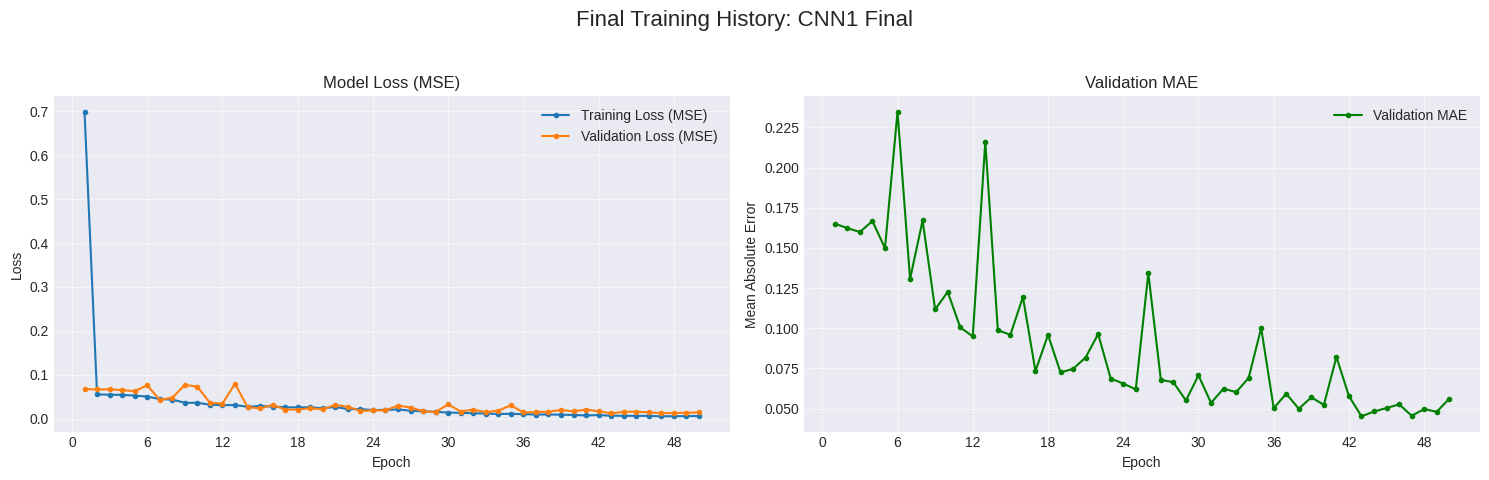

 Error saving plot: [Errno 30] Read-only file system: '/kaggle/input/st311-tennis/cnn2_final_training_plot.png'


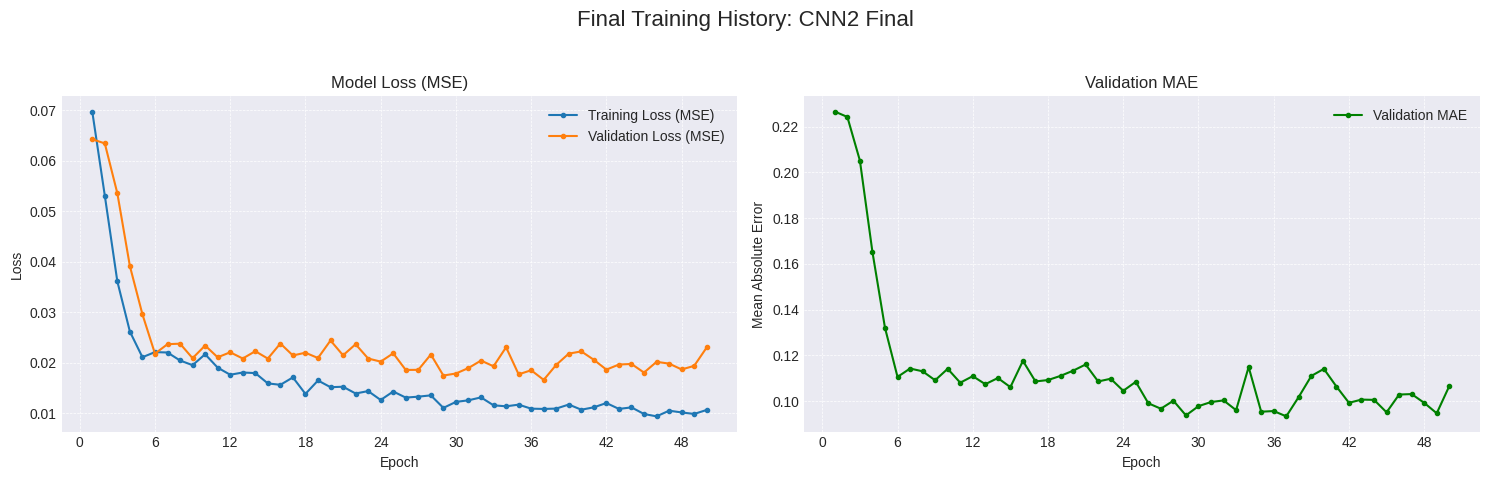

In [ ]:
def plot_training_history(history_data, model_name, save_path=None):
    """Plots training history from dict or loaded CSV."""
    history = None
    if isinstance(history_data, str) and os.path.exists(history_data):
        try: history = pd.read_csv(history_data).to_dict(orient='list'); print(f"Loaded history: {os.path.basename(history_data)}")
        except Exception as e: print(f"Error loading history {os.path.basename(history_data)}: {e}"); return
    elif isinstance(history_data, dict): history = history_data
    if not history or 'train_loss' not in history or 'val_loss' not in history: print(f"Invalid history for {model_name}."); return
    epochs_trained = len(history['train_loss'])
    if epochs_trained == 0: print(f"No epochs in history for {model_name}."); return

    epoch_range = range(1, epochs_trained + 1)
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"Final Training History: {model_name}", fontsize=16)
    # Loss Plot
    axes[0].plot(epoch_range, history['train_loss'], marker='.', label='Training Loss (MSE)')
    axes[0].plot(epoch_range, history['val_loss'], marker='.', label='Validation Loss (MSE)')
    axes[0].set_title('Model Loss (MSE)'); axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
    axes[0].legend(); axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True, min_n_ticks=5))
    # MAE Plot
    if 'val_mae' in history and history['val_mae'] and not np.all(pd.isna(history['val_mae'])):
        axes[1].plot(epoch_range, history['val_mae'], marker='.', label='Validation MAE', color='green')
        axes[1].set_title('Validation MAE'); axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Mean Absolute Error')
        axes[1].legend(); axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
        axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True, min_n_ticks=5))
    else: axes[1].set_title('Validation MAE (No Data)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]);
    if save_path:
        try: plt.savefig(save_path, dpi=300); print(f" Plot saved: {save_path}")
        except Exception as e: print(f" Error saving plot: {e}")
    plt.show(); plt.close()

# Plot histories if available (from variables or files)
print("\nPlotting Histories...")
cnn1_history_path = os.path.join(project_path, 'cnn1_final_training_history.csv')
cnn1_plot_path = os.path.join(project_path, 'cnn1_final_training_plot.png')
plot_training_history(cnn1_history if 'cnn1_history' in locals() else cnn1_history_path, "CNN1 Final", cnn1_plot_path)

cnn2_history_path = os.path.join(project_path, 'cnn2_final_training_history.csv')
cnn2_plot_path = os.path.join(project_path, 'cnn2_final_training_plot.png')
plot_training_history(cnn2_history if 'cnn2_history' in locals() else cnn2_history_path, "CNN2 Final", cnn2_plot_path)

## Prediction Pipeline

Runs a full pipeline example: video sent to CNN1, where most likely frame in which the hit occurs is identified. Then frame sequence surrounding hit frame is sent to CNN2, where normalised landing point is predicted and then denormalised to provide real-world prediction.

### Helper Functions (Model Loading, Denormalisation)

In [ ]:
def load_hit_model(model_path, device):
    """Loads the trained HitFrameRegressorFinal model."""
    try:
        # Instantiate with final architecture parameters from config
        model = HitFrameRegressorFinal(
            block_filters=CNN1_FILTERS, fc_size=CNN1_FC_SIZE, dropout_rate=CNN1_DROPOUT
        ).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval(); print(f"Hit Model loaded from {os.path.basename(model_path)}")
        return model
    except Exception as e: print(f"Error loading Hit model {os.path.basename(model_path)}: {e}"); return None

def load_landing_model(model_path, device):
    """Loads the trained LandingPointCNN model."""
    try:
        # Instantiate with final architecture parameters from config
        input_channels = CNN2_N_FRAMES_SEQUENCE * 3
        model = LandingPointCNN(
            input_channels=input_channels, conv_filters=CNN2_CONV_FILTERS,
            fc_sizes=CNN2_FC_SIZES, dropout_rate=CNN2_DROPOUT
        ).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval(); print(f"Landing Model loaded from {os.path.basename(model_path)}")
        return model
    except Exception as e: print(f"Error loading Landing model {os.path.basename(model_path)}: {e}"); return None

def denormalize_coordinates(norm_x, norm_y, court_width=DOUBLES_COURT_WIDTH_M, court_length=HALF_COURT_LENGTH_M):
    """Converts normalized [0, 1] coords back to approx metric distances."""
    norm_x, norm_y = np.clip(norm_x, 0, 1), np.clip(norm_y, 0, 1)
    if court_width <= 0 or court_length <= 0: return None, None, None
    dist_from_left_m = norm_x * court_width
    dist_from_right_m = court_width - dist_from_left_m
    dist_from_baseline_m = norm_y * court_length # Y=0 baseline -> Y=1 net
    return dist_from_left_m, dist_from_right_m, dist_from_baseline_m

print("Prediction helper functions defined.")

Prediction helper functions defined.


### Combined Prediction Pipeline Function

In [ ]:
def predict_hit_and_landing(cnn1_model, cnn2_model, frames_directory,
                            device, img_height, img_width, n_frames_sequence):
    """Runs the full prediction pipeline using pre-loaded models."""
    print(f"\n--- Running Prediction Pipeline for: {os.path.basename(frames_directory)} ---")
    if not cnn1_model or not cnn2_model: print(" ERR: Models not loaded."); return None, None
    if n_frames_sequence % 2 == 0: print(" WARN: n_frames_sequence should be odd."); n_frames_sequence+=1

    # --- Part 1: Find Hit Frame using CNN1 ---
    try: # List, sort frames
        all_files=os.listdir(frames_directory); image_extensions=('.jpg','.jpeg','.png','.bmp','.tiff')
        frames_with_numbers=[{'path': os.path.join(frames_directory, f), 'number': int(match.group(1)), 'basename': f}
                             for f in all_files if f.lower().endswith(image_extensions) and (match := re.search(r'(\d+)', f))]
        if not frames_with_numbers: print(f"ERR: No parsable frames in {frames_directory}"); return None, None
        sorted_frames = sorted(frames_with_numbers, key=lambda x: x['number'])
        sorted_frame_paths = [f['path'] for f in sorted_frames]; num_total_frames = len(sorted_frame_paths)
        print(f" Found and sorted {num_total_frames} frames.")
    except Exception as e: print(f"ERR listing/sorting frames: {e}"); return None, None

    # CNN1 Inference
    predictions_cnn1 = []
    print(" Running Hit Frame detection (CNN1)...")
    with torch.no_grad():
        for frame_path in tqdm(sorted_frame_paths, desc="CNN1 Infer", leave=False, ncols=70):
            try: # Preprocess & Predict
                img = cv2.imread(frame_path);
                if img is None: continue
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized=cv2.resize(img_rgb,(img_width, img_height))
                img_norm=(img_resized / 255.0).astype(np.float32)
                img_chw=np.transpose(img_norm, (2,0,1))
                inp = torch.from_numpy(img_chw).unsqueeze(0).to(device)
                score = cnn1_model(inp).item()
                predictions_cnn1.append({'path': frame_path, 'score': score})
            except Exception as e: print(f" ERR CNN1 on {os.path.basename(frame_path)}: {e}")
    if not predictions_cnn1: print(" ERR: No CNN1 predictions."); return None, None
    best_hit = max(predictions_cnn1, key=lambda x: x['score'])
    pred_hit_path = best_hit['path']
    print(f" Predicted Hit Frame: {os.path.basename(pred_hit_path)} (Score: {best_hit['score']:.4f})")

    # --- Part 2: Construct Sequence ---
    try: pred_hit_idx = sorted_frame_paths.index(pred_hit_path)
    except ValueError: print(" ERR: Predicted hit not found in list."); return None, pred_hit_path
    half_win = n_frames_sequence // 2
    start_idx, end_idx = pred_hit_idx - half_win, pred_hit_idx + half_win
    indices = np.clip(np.arange(start_idx, end_idx + 1), 0, num_total_frames - 1)
    sequence_paths = [sorted_frame_paths[i] for i in indices]
    if len(sequence_paths) != n_frames_sequence: print(" ERR: Sequence length mismatch."); return None, pred_hit_path

    # --- Part 3: Predict Landing Spot using CNN2 ---
    print(" Preprocessing sequence for CNN2...")
    sequence_tensors = []
    try: # Preprocess sequence
        for frame_path in sequence_paths:
            img = cv2.imread(frame_path);
            if img is None: raise IOError(f"Load failed: {frame_path}")
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized=cv2.resize(img_rgb,(img_width, img_height))
            img_norm=(img_resized / 255.0).astype(np.float32)
            img_chw=np.transpose(img_norm, (2,0,1))
            sequence_tensors.append(torch.from_numpy(img_chw))
        stacked_tensor = torch.cat(sequence_tensors, dim=0) # [C*T, H, W]
        input_batch_cnn2 = stacked_tensor.unsqueeze(0).to(device) # [1, C*T, H, W]
    except Exception as e: print(f" ERR preprocessing CNN2 seq: {e}"); return None, pred_hit_path

    # CNN2 Inference
    print(" Running Landing Prediction (CNN2)...")
    with torch.no_grad(): pred_coords_tensor = cnn2_model(input_batch_cnn2)
    pred_norm_x, pred_norm_y = pred_coords_tensor[0, 0].item(), pred_coords_tensor[0, 1].item()
    predicted_norm_coords = (pred_norm_x, pred_norm_y)
    print(f" Predicted Landing Coords (Norm): ({pred_norm_x:.4f}, {pred_norm_y:.4f})")
    print("--- Prediction Pipeline Finished ---")
    return predicted_norm_coords, pred_hit_path

print("Combined prediction pipeline function defined.")

Combined prediction pipeline function defined.


### Run Prediction Example

Using example directory from test set: ICT46
  Actual Coords: (0.180, 0.102)
Initializing HitFrameRegressorFinal:
  - Filters: (32, 32, 64, 64), FC Size: 512, Dropout: 0.5
  - Final Model Flattened Size: 12544
  - Final Model FC Block: 12544 -> 512 -> 1
Hit Model loaded from cnn1_hit_frame_regressor_final.pth
Initializing LandingPointCNN:
  - Input Channels: 27
  - Conv Filters: (128, 256, 512, 512)
  - FC Sizes: (512, 256)
  - Dropout: 0.5
  - Final CNN2 Flattened size: 25088 (512x7x7)
  - Final CNN2 FC block built.
Landing Model loaded from cnn2_landing_spot_predictor_final.pth

--- Running Prediction Pipeline for: ICT46 ---
 Found and sorted 103 frames.
 Running Hit Frame detection (CNN1)...


CNN1 Infer:   0%|                             | 0/103 [00:00<?, ?it/s]

 Predicted Hit Frame: frame_0065.jpg (Score: 0.8936)
 Preprocessing sequence for CNN2...
 Running Landing Prediction (CNN2)...
 Predicted Landing Coords (Norm): (0.4029, 0.3162)
--- Prediction Pipeline Finished ---

--- Example Pipeline Results ---
Predicted Hit: frame_0065.jpg
Predicted Landing (Norm): (0.4028908312320709, 0.31618183851242065)
Predicted Landing (Meters): L=4.42, R=6.55, Base=3.76
Normalized Euclidean Error: 0.3096


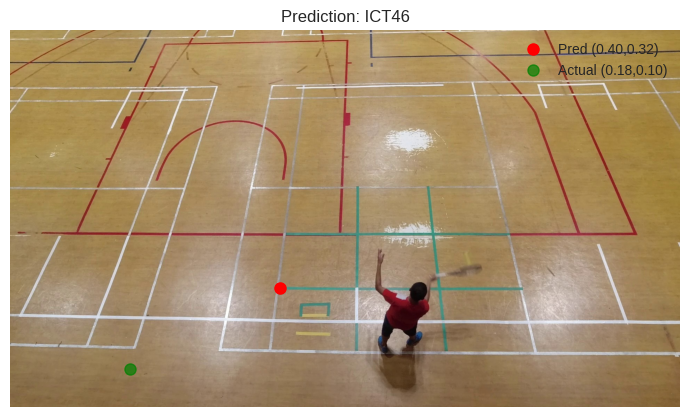

In [ ]:
# Define paths to FINAL trained models
cnn1_model_path = os.path.join(project_path, 'cnn1_hit_frame_regressor_final.pth')
cnn2_model_path = os.path.join(project_path, 'cnn2_landing_spot_predictor_final.pth')

# Select an example directory
example_frames_dir = None
actual_coords_example = None
if test_sequences_cnn2: # Use test set if available
    example_sequence_info = random.choice(test_sequences_cnn2)
    if example_sequence_info.get('sequence_paths'):
         example_frames_dir = os.path.dirname(example_sequence_info['sequence_paths'][0])
         actual_coords_example = example_sequence_info.get('target_coords')
         print(f"Using example directory from test set: {os.path.basename(example_frames_dir)}")
         if actual_coords_example: print(f"  Actual Coords: ({actual_coords_example[0]:.3f}, {actual_coords_example[1]:.3f})")
    else: print("WARN: Test sequence dict invalid.")
elif dataset_base_path: # Fallback to finding any directory
    frames_root = os.path.join(dataset_base_path, 'Frames')
    try:
        potential_dirs = [os.path.join(dp, d) for dp, dn, fn in os.walk(frames_root) for d in dn if re.match(r'^(ICT|IST|OCT|OST)\d+$', d)]
        if potential_dirs: example_frames_dir = random.choice(potential_dirs); print(f"Using fallback example directory: {os.path.basename(example_frames_dir)}")
        else: print("ERR: No example directories found in dataset.")
    except Exception as e: print(f"Error finding fallback directory: {e}")
else: print("ERR: Cannot find example directory (dataset path missing).")

# --- Check files and run ---
if os.path.exists(cnn1_model_path) and os.path.exists(cnn2_model_path) and example_frames_dir and os.path.isdir(example_frames_dir):
    # Load models once
    cnn1_pred_model = load_hit_model(cnn1_model_path, DEVICE)
    cnn2_pred_model = load_landing_model(cnn2_model_path, DEVICE)

    if cnn1_pred_model and cnn2_pred_model:
        predicted_coords, hit_frame_file = predict_hit_and_landing(
            cnn1_model=cnn1_pred_model, # Pass loaded models
            cnn2_model=cnn2_pred_model,
            frames_directory=example_frames_dir,
            device=DEVICE,
            img_height=IMG_HEIGHT, # Use global IMG_HEIGHT/WIDTH
            img_width=IMG_WIDTH,
            n_frames_sequence=CNN2_N_FRAMES_SEQUENCE # Use config value
        )

        # Display Results
        if predicted_coords and hit_frame_file:
            print("\n--- Example Pipeline Results ---")
            print(f"Predicted Hit: {os.path.basename(hit_frame_file)}")
            print(f"Predicted Landing (Norm): {predicted_coords}")
            d_left, d_right, d_base = denormalize_coordinates(*predicted_coords)
            if d_left is not None: print(f"Predicted Landing (Meters): L={d_left:.2f}, R={d_right:.2f}, Base={d_base:.2f}")
            if actual_coords_example:
                 err = np.sqrt((predicted_coords[0]-actual_coords_example[0])**2 + (predicted_coords[1]-actual_coords_example[1])**2)
                 print(f"Normalized Euclidean Error: {err:.4f}")
            # Visualize hit frame with prediction
            try:
                img_hit = cv2.imread(hit_frame_file); img_rgb = cv2.cvtColor(img_hit, cv2.COLOR_BGR2RGB)
                h, w, _ = img_rgb.shape; marker_x = int(predicted_coords[0] * w); marker_y = int((1.0 - predicted_coords[1]) * h)
                plt.figure(figsize=(7, 6)); plt.imshow(img_rgb)
                plt.plot(marker_x, marker_y, 'ro', markersize=8, label=f'Pred ({predicted_coords[0]:.2f},{predicted_coords[1]:.2f})')
                if actual_coords_example:
                    act_x = int(actual_coords_example[0]*w); act_y = int((1.0-actual_coords_example[1])*h)
                    plt.plot(act_x, act_y, 'go', markersize=8, alpha=0.7, label=f'Actual ({actual_coords_example[0]:.2f},{actual_coords_example[1]:.2f})')
                plt.title(f"Prediction: {os.path.basename(example_frames_dir)}"); plt.legend(); plt.axis('off'); plt.tight_layout(); plt.show(); plt.close()
            except Exception as e: print(f"Viz Error: {e}")
        else: print("\n--- Example Pipeline Failed ---")
    else: print("Failed to load models for prediction.")
else:
    print("\nSkipping prediction example: Model files or example directory not found.")
    print(f" Checked CNN1: {cnn1_model_path} (Exists: {os.path.exists(cnn1_model_path)})")
    print(f" Checked CNN2: {cnn2_model_path} (Exists: {os.path.exists(cnn2_model_path)})")
    print(f" Checked Dir: {example_frames_dir} (Exists: {os.path.isdir(example_frames_dir or '')})")